<a href="https://colab.research.google.com/github/youngpaper1115/Lending-Club-Project/blob/main/%ED%86%B5%EB%8D%B0%EC%82%AC%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. 기본 파트

In [ ]:
#google drive mount 및 파일 경로 지정

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 필요 라이브러리 import 및 현재 작업공간 확인

# 기본 라이브러리
import pandas as pd
import numpy as np
import os

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
%matplotlib inline

# 통계 및 기계학습 관련 라이브러리
from scipy import stats    # 통계 관련 라이브러리
from sklearn.model_selection import train_test_split, RandomizedSearchCV    # 데이터 셋 분류 라이브러리
from sklearn.utils import resample    # 데이터 업샘플링&다운샘플링 라이브러리
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN    # 복합샘플링 라이브러리
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler    # 데이터 스케일링 라이브러리
from statsmodels.stats.outliers_influence import variance_inflation_factor    # 변수 간 다중공선성 확인(VIF) 라이브러리
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, plot_confusion_matrix, plot_roc_curve)    # 모델 정확도 검증 라이브러리
from sklearn.model_selection import cross_val_score    # validation  검증 라이브러리
from sklearn.linear_model import LogisticRegression    # 로지스틱 회귀 라이브러리
from sklearn.linear_model import Lasso    # 라쏘 라이브러리
from sklearn.linear_model import Ridge    # 릿지 라이브러리
import statsmodels.api as sm    # 통계분석 관련 라이브러리
from xgboost import XGBClassifier    # XGBoost 라이브러리
from sklearn.ensemble import RandomForestClassifier    # 랜덤포레스트 라이브러리
import warnings    # 경고문구 지우기


# 작업공간 확인
os.getcwd()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'/content'

In [ ]:
# 데이터 불러오기
lc_df = pd.read_stata('/content/gdrive/My Drive/python/data3/lendingclub.dta')

# emp_length 결과 불러오기
result_list = []
f = open('/content/gdrive/My Drive/python/data3/emp_length.txt', 'r')
numb = f.read()
f.close()
result_list = numb.split(",")
del result_list[-1]

# raw data에 emp_length 컬럼 추가
lc_df['emp_length'] = result_list
lc_df = lc_df.astype({'emp_length': 'int'})

## 1. 데이터 탐색 (EDA)

#### 1-1. 결측치 확인
  - 결측치 존재하지 않음

In [ ]:
lc_df.columns[lc_df.isna().sum() != 0]

Index([], dtype='object')

#### 1-2. 이상치 제거
  - 이상치가 존재하지 않는 더미 변수 or 범주 변수는 따로 분석하지 않음
  - 1.5 IQR(Inter Quantile Range)를 기준으로 이상치를 제거할 경우 많은 데이터 손실 예상
  => 데이터 손실(Loss)을 최소로 하기 위해 Box Plot 확인 후 차이가 너무 큰 값만 제외

<function matplotlib.pyplot.show>

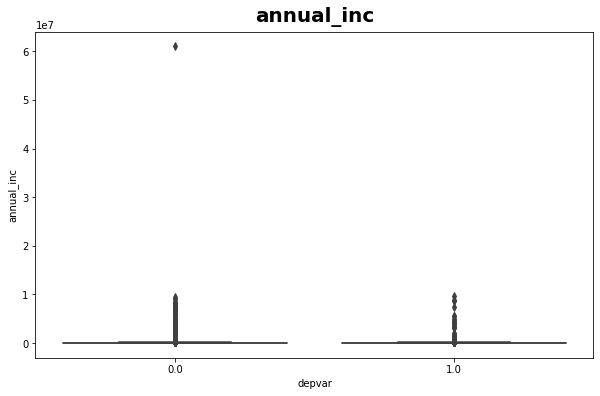

In [ ]:
title_font = {'fontsize': 20, 'fontweight': 'bold'}
plt.figure(figsize=(10,6))
sns.boxplot(y=lc_df['annual_inc'], x=lc_df['depvar'])
plt.title('annual_inc', fontdict=title_font, pad = 10)
plt.show

<function matplotlib.pyplot.show>

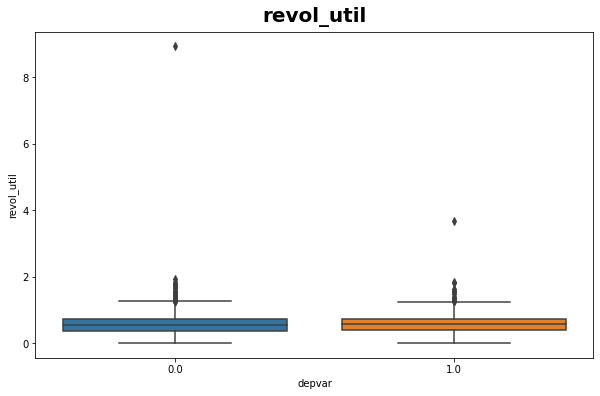

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(y=lc_df['revol_util'], x=lc_df['depvar'])
plt.title('revol_util', fontdict=title_font, pad = 10)
plt.show

<function matplotlib.pyplot.show>

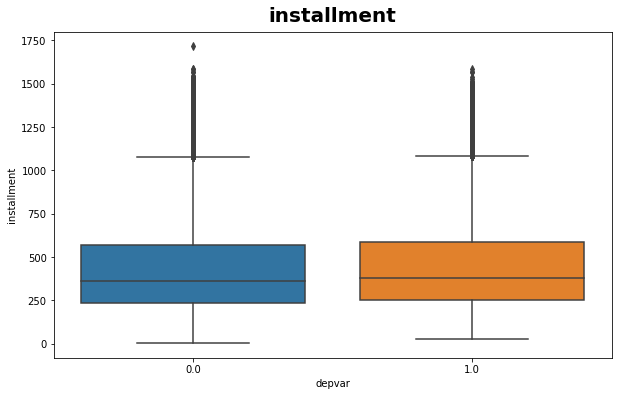

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(y=lc_df['installment'], x=lc_df['depvar'])
plt.title('installment', fontdict=title_font, pad = 10)
plt.show

<function matplotlib.pyplot.show>

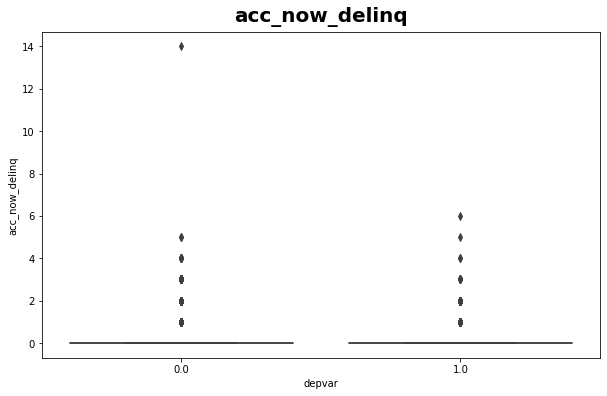

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(y=lc_df['acc_now_delinq'],x=lc_df['depvar'])
plt.title('acc_now_delinq', fontdict=title_font, pad = 10)
plt.show

<function matplotlib.pyplot.show>

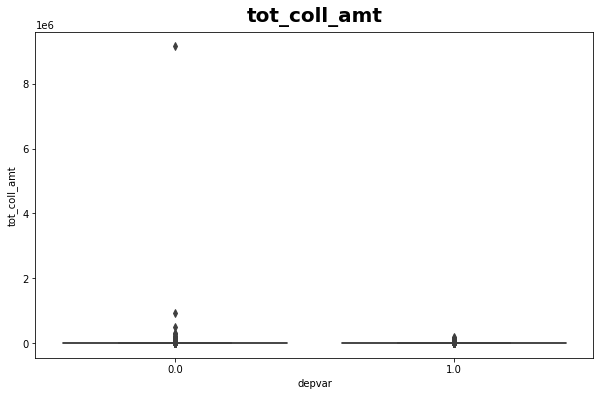

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(y=lc_df["tot_coll_amt"],x=lc_df['depvar'])
plt.title('tot_coll_amt', fontdict=title_font, pad = 10)
plt.show

<function matplotlib.pyplot.show>

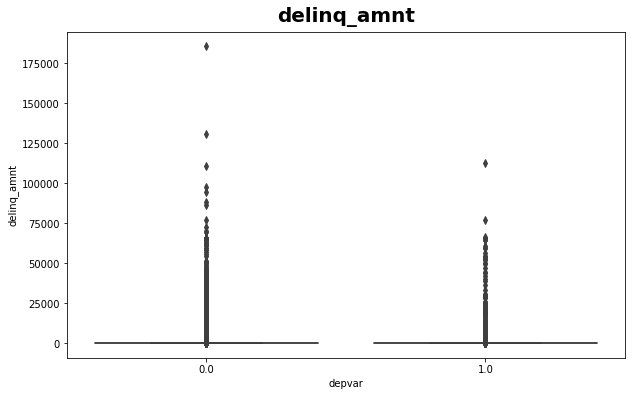

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(y=lc_df["delinq_amnt"],x=lc_df['depvar'])
plt.title('delinq_amnt', fontdict=title_font, pad = 10)
plt.show

- 제거 목록
  - annual_inc : 너무 큰 값이 1개 존재하여 이를 제거 (이정도 연수입에 대출받을 필요가 없을 것이라 판단)
  - tot_coll_amt : 너무 큰 값이 2개 존재하여 이를 제거 (채무액이 큰 상황에서 동시에 채무를 이행하는 것이 불가능하다 판단)

<function matplotlib.pyplot.show>

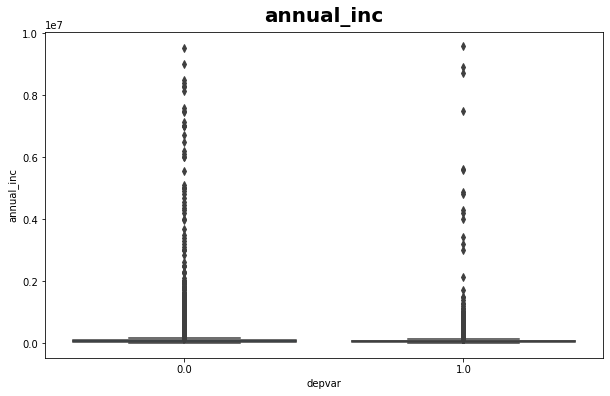

In [ ]:
lc_df = lc_df.drop(index = lc_df[lc_df['annual_inc'] == lc_df['annual_inc'].max()].index)    # annual_inc 변수의 max값 index를 찾은 후 해당 데이터 제거
plt.figure(figsize=(10,6))
sns.boxplot(y=lc_df['annual_inc'], x=lc_df['depvar'])
plt.title('annual_inc', fontdict=title_font, pad = 10)
plt.show

<function matplotlib.pyplot.show>

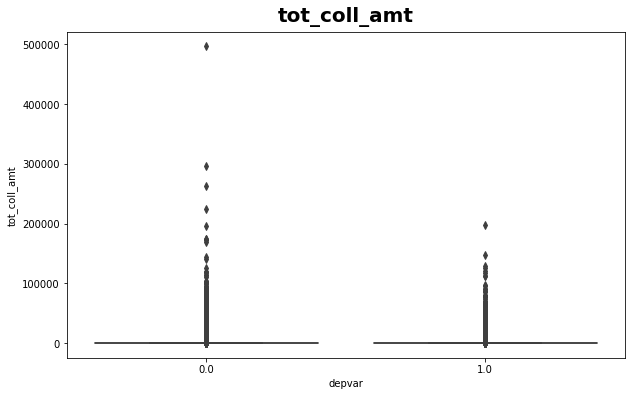

In [ ]:
lc_df = lc_df.drop(index = lc_df[lc_df['tot_coll_amt'] == lc_df['tot_coll_amt'].max()].index)    # tot_coll_amt 변수의 max값 index를 찾은 후 해당 데이터 제거
lc_df = lc_df.drop(index = lc_df[lc_df['tot_coll_amt'] == lc_df['tot_coll_amt'].max()].index)    # tot_coll_amt 변수의 max값 index를 찾은 후 해당 데이터 제거(2번째 값)
plt.figure(figsize=(10,6))
sns.boxplot(y=lc_df["tot_coll_amt"],x=lc_df['depvar'])
plt.title('tot_coll_amt', fontdict=title_font, pad = 10)
plt.show

#### 1-3. 변수별 탐색 : pivot table을 생성하여 불량률 비교

(1) 변수가 여러 컬럼으로 분류되어 있는 경우

In [ ]:
def make_pivot_table(columns, lc_df) :
  # 특정 변수와 종속 변수만 불러온 임시 데이터프레임 생성
  temp_list = list(filter(lambda x: columns in x, lc_df.columns.tolist()))    # 입력 컬럼명만 포함되는 컬럼리스트 추출
  if columns == 'mths_since_recent_bc' :
    temp_list = temp_list[:11]
  temp_list.append('depvar')     # 변환 리스트에 종속변수 'depvar'값 추가
  temp_df = lc_df[temp_list]

  # 우량 / 불량 집단으로 분류
  good_temp = temp_df[temp_df['depvar'] == 0]     # depvar = 0의 경우. 상환 완료
  bad_temp = temp_df[temp_df['depvar'] == 1]      # depvar = 1의 경우, 상환X

  # 우량 / 불량 집단 별 합계
  good_sum = good_temp.sum(axis = 0)
  bad_sum = bad_temp.sum(axis = 0)

  # 전체 값 대비 비율 생성
  temp_ratio = []
  for i in temp_list[:-1] :
    temp_ratio.append(len(temp_df[temp_df[i] == 1]) / len(temp_df))
  
  # index 별 전체 대비 불량 비율(불량률)
  bad_ratio = round((bad_sum[:-1] / (good_sum[:-1] + bad_sum[:-1]))*100, 2)

  pivot_table = pd.DataFrame(index = temp_list[:-1])

  temp_ratio = []
  for i in temp_list[:-1] :
    value = len(temp_df[temp_df[i] == 1]) / len(temp_df)
    temp_ratio.append(str(round(value*100, 2)) + '%')

  pivot_table['whole(%)'] = temp_ratio
  pivot_table['good'] = good_sum[:-1]
  pivot_table['bad'] = bad_sum[:-1]
  pivot_table['bad ratio(%)'] = bad_ratio

  return pivot_table

In [ ]:
# home ownership 변수 : 1,2 / 3,4,5,6 에서 차이가 보임
home_pt = make_pivot_table('home_ownership', lc_df)
home_pt

,whole(%),good,bad,bad ratio(%)
home_ownership1,0.03%,331.0,51.0,13.35
home_ownership2,48.11%,453144.0,72688.0,13.82
home_ownership3,0.0%,35.0,7.0,16.67
home_ownership4,0.0%,37.0,8.0,17.78
home_ownership5,10.94%,99788.0,19789.0,16.55
home_ownership6,40.9%,362757.0,84281.0,18.85


In [ ]:
# mths_since_last_delinq 변수 : 1 / 2~11
mths_pt1 = make_pivot_table('mths_since_last_delinq', lc_df)
mths_pt1

,whole(%),good,bad,bad ratio(%)
mths_since_last_delinq1,49.09%,451987.0,84520.0,15.75
mths_since_last_delinq2,5.22%,47379.0,9669.0,16.95
mths_since_last_delinq3,5.87%,53179.0,11025.0,17.17
mths_since_last_delinq4,4.57%,41494.0,8431.0,16.89
mths_since_last_delinq5,5.1%,46674.0,9077.0,16.28
mths_since_last_delinq6,4.84%,44067.0,8824.0,16.68
mths_since_last_delinq7,5.1%,46702.0,9073.0,16.27
mths_since_last_delinq8,5.31%,48688.0,9298.0,16.03
mths_since_last_delinq9,4.95%,45252.0,8817.0,16.31
mths_since_last_delinq10,4.94%,44970.0,9011.0,16.69


In [ ]:
# mths_since_last_major_derog 변수 : 1 / 2~11
mths_pt2 = make_pivot_table('mths_since_last_major_derog', lc_df)
mths_pt2

,whole(%),good,bad,bad ratio(%)
mths_since_last_major_derog1,72.14%,665235.0,123212.0,15.63
mths_since_last_major_derog2,2.87%,25600.0,5714.0,18.25
mths_since_last_major_derog3,3.04%,27392.0,5872.0,17.65
mths_since_last_major_derog4,2.78%,25058.0,5275.0,17.39
mths_since_last_major_derog5,2.86%,25693.0,5555.0,17.78
mths_since_last_major_derog6,2.58%,23365.0,4827.0,17.12
mths_since_last_major_derog7,2.94%,26698.0,5488.0,17.05
mths_since_last_major_derog8,2.64%,23801.0,5052.0,17.51
mths_since_last_major_derog9,2.59%,23309.0,4966.0,17.56
mths_since_last_major_derog10,2.88%,25933.0,5515.0,17.54


In [ ]:
# mths_since_last_record 변수 : 1 / 2~11
mths_pt3 = make_pivot_table('mths_since_last_record', lc_df)
mths_pt3

,whole(%),good,bad,bad ratio(%)
mths_since_last_record1,82.59%,761020.0,141638.0,15.69
mths_since_last_record2,1.78%,15947.0,3456.0,17.81
mths_since_last_record3,1.76%,15897.0,3319.0,17.27
mths_since_last_record4,1.74%,15768.0,3298.0,17.30
mths_since_last_record5,1.88%,16905.0,3682.0,17.89
mths_since_last_record6,1.78%,15986.0,3507.0,17.99
mths_since_last_record7,1.8%,15976.0,3643.0,18.57
mths_since_last_record8,1.65%,14476.0,3504.0,19.49
mths_since_last_record9,1.66%,14498.0,3635.0,20.05
mths_since_last_record10,1.78%,15566.0,3885.0,19.97


In [ ]:
# mths_since_rcnt_il : 1 / 2~5 / 6~11
mths_pt4 = make_pivot_table('mths_since_rcnt_il', lc_df)
mths_pt4

,whole(%),good,bad,bad ratio(%)
mths_since_rcnt_il1,64.4%,587562.0,116243.0,16.52
mths_since_rcnt_il2,5.15%,45127.0,11181.0,19.86
mths_since_rcnt_il3,3.14%,28259.0,6077.0,17.70
mths_since_rcnt_il4,3.23%,29196.0,6146.0,17.39
mths_since_rcnt_il5,2.76%,25012.0,5103.0,16.95
mths_since_rcnt_il6,4.03%,37296.0,6780.0,15.38
mths_since_rcnt_il7,3.24%,30263.0,5158.0,14.56
mths_since_rcnt_il8,3.65%,34325.0,5566.0,13.95
mths_since_rcnt_il9,3.36%,31896.0,4791.0,13.06
mths_since_rcnt_il10,3.48%,33313.0,4736.0,12.45


In [ ]:
 # mths_since_recent_bc : 1~6 / 7~11
 mths_pt5 = make_pivot_table('mths_since_recent_bc', lc_df)
 mths_pt5

,whole(%),good,bad,bad ratio(%)
mths_since_recent_bc1,0.92%,8301.0,1708.0,17.06
mths_since_recent_bc2,13.56%,119227.0,29018.0,19.57
mths_since_recent_bc3,9.09%,81442.0,17925.0,18.04
mths_since_recent_bc4,8.0%,71866.0,15529.0,17.77
mths_since_recent_bc5,10.08%,91317.0,18903.0,17.15
mths_since_recent_bc6,11.19%,101439.0,20911.0,17.09
mths_since_recent_bc7,8.37%,76561.0,14918.0,16.31
mths_since_recent_bc8,10.24%,94818.0,17101.0,15.28
mths_since_recent_bc9,9.42%,88058.0,14885.0,14.46
mths_since_recent_bc10,9.28%,87858.0,13542.0,13.36


In [ ]:
# mths_since_recent_bc_dlq : 1 / 2~11
mths_pt6 = make_pivot_table('mths_since_recent_bc_dlq', lc_df)
mths_pt6

,whole(%),good,bad,bad ratio(%)
mths_since_recent_bc_dlq1,74.48%,684096.0,129915.0,15.96
mths_since_recent_bc_dlq2,2.71%,24523.0,5079.0,17.16
mths_since_recent_bc_dlq3,2.61%,23558.0,4988.0,17.47
mths_since_recent_bc_dlq4,2.61%,23726.0,4754.0,16.69
mths_since_recent_bc_dlq5,2.62%,23835.0,4790.0,16.73
mths_since_recent_bc_dlq6,2.57%,23596.0,4485.0,15.97
mths_since_recent_bc_dlq7,2.54%,23293.0,4511.0,16.22
mths_since_recent_bc_dlq8,2.35%,21491.0,4215.0,16.40
mths_since_recent_bc_dlq9,2.56%,23149.0,4824.0,17.25
mths_since_recent_bc_dlq10,2.48%,22472.0,4663.0,17.18


In [ ]:
# mths_since_recent_inq : 1 / 2~6 / 7~11
mths_pt7 = make_pivot_table('mths_since_recent_inq', lc_df)
mths_pt7

,whole(%),good,bad,bad ratio(%)
mths_since_recent_inq1,10.63%,103055.0,13166.0,11.33
mths_since_recent_inq2,17.91%,156642.0,39048.0,19.95
mths_since_recent_inq3,15.25%,136284.0,30420.0,18.25
mths_since_recent_inq4,6.59%,59621.0,12388.0,17.20
mths_since_recent_inq5,5.87%,53451.0,10676.0,16.65
mths_since_recent_inq6,10.23%,93687.0,18149.0,16.23
mths_since_recent_inq7,8.21%,75827.0,13932.0,15.52
mths_since_recent_inq8,9.05%,84106.0,14757.0,14.93
mths_since_recent_inq9,8.05%,75389.0,12578.0,14.30
mths_since_recent_inq10,8.21%,78030.0,11710.0,13.05


In [ ]:
# mths_since_recent_revol_delinq : 큰 차이 없음
mths_pt8 = make_pivot_table('mths_since_recent_revol_delinq', lc_df)
mths_pt8

,whole(%),good,bad,bad ratio(%)
mths_since_recent_revol_delinq1,64.49%,592016.0,112845.0,16.01
mths_since_recent_revol_delinq2,3.84%,34923.0,7024.0,16.74
mths_since_recent_revol_delinq3,3.81%,34489.0,7100.0,17.07
mths_since_recent_revol_delinq4,3.61%,32937.0,6521.0,16.53
mths_since_recent_revol_delinq5,3.45%,31467.0,6277.0,16.63
mths_since_recent_revol_delinq6,3.23%,29449.0,5826.0,16.52
mths_since_recent_revol_delinq7,3.58%,32962.0,6118.0,15.66
mths_since_recent_revol_delinq8,3.78%,34688.0,6613.0,16.01
mths_since_recent_revol_delinq9,3.36%,30727.0,6005.0,16.35
mths_since_recent_revol_delinq10,3.58%,32543.0,6550.0,16.75


(2) 범주화가 되어있는 변수들의 추가 작업 필요 여부 확인

In [ ]:
def make_pivot_table2(columns, lc_df) :
  # 컬럼명과 종속변수만 추출
  temp_df = lc_df[[columns, 'depvar']]

  # 우량 / 불량 집단으로 분류
  good_temp = temp_df[temp_df['depvar'] == 0]     # depvar = 0의 경우. 상환 완료
  bad_temp = temp_df[temp_df['depvar'] == 1]      # depvar = 1의 경우, 상환X

  # 피봇테이블 생성
  pivot_table = pd.DataFrame(index = temp_df[columns].value_counts().index)
  
  temp_ratio = []
  for i in temp_df[columns].value_counts().index.tolist() :
    temp_ratio.append(str(round((temp_df[columns].value_counts()[i] / len(temp_df))*100, 2)) + '%')

  pivot_table['whole(%)'] = temp_ratio
  pivot_table['good'] = good_temp[columns].value_counts()
  pivot_table['bad'] = bad_temp[columns].value_counts()
  pivot_table['bad ratio(%)'] = round((pivot_table['bad'] / (pivot_table['good'] + pivot_table['bad']))*100, 2)

  return pivot_table

In [ ]:
# inq_last_6mths : 0 / 1 / 2~
il6_pt = make_pivot_table2('inq_last_6mths', lc_df)
il6_pt

,whole(%),good,bad,bad ratio(%)
0,58.17%,545744,89995.0,14.16
1,26.89%,242108,51730.0,17.60
2,9.79%,85044,21944.0,20.51
3,3.61%,30386,9042.0,22.93
4,1.09%,9027,2891.0,24.26
5,0.38%,3119,1016.0,24.57
6,0.08%,660,206.0,23.79
7,0.0%,3,NaN,NaN
8,0.0%,1,NaN,NaN


In [ ]:
# delinq_2yrs : 0 / 1~11 / 12~
d2y_pt = make_pivot_table2('delinq_2yrs', lc_df)
d2y_pt

,whole(%),good,bad,bad ratio(%)
0,79.64%,731269,139099.0,15.98
1,13.38%,122089,24141.0,16.51
2,4.02%,36259,7629.0,17.38
3,1.48%,13167,2985.0,18.48
4,0.67%,6027,1315.0,17.91
5,0.34%,3031,681.0,18.35
6,0.19%,1705,377.0,18.11
7,0.11%,925,230.0,19.91
8,0.06%,559,114.0,16.94
9,0.04%,340,82.0,19.43


In [ ]:
# collections_12_mths_ex_med : 0 / 1~
c12_pt = make_pivot_table2('collections_12_mths_ex_med', lc_df)
c12_pt

,whole(%),good,bad,bad ratio(%)
0,98.37%,901761,173297.0,16.12
1,1.51%,13295,3256.0,19.67
2,0.1%,863,237.0,21.55
3,0.01%,107,22.0,17.05
4,0.0%,34,9.0,20.93
5,0.0%,15,1.0,6.25
6,0.0%,4,2.0,33.33
7,0.0%,3,NaN,NaN
20,0.0%,2,NaN,NaN
10,0.0%,2,NaN,NaN


In [ ]:
# acc_now_delinq : 0 / 1~
and_pt = make_pivot_table2('acc_now_delinq', lc_df)
and_pt

,whole(%),good,bad,bad ratio(%)
0,99.45%,911139.0,175798.0,16.17
1,0.51%,4659.0,958.0,17.06
2,0.03%,251.0,56.0,18.24
3,0.0%,31.0,8.0,20.51
4,0.0%,9.0,2.0,18.18
5,0.0%,2.0,1.0,33.33
6,0.0%,NaN,1.0,NaN
14,0.0%,1.0,NaN,NaN


In [ ]:
# pub_rec_bankruptcies : 0 / 1~
and_pt = make_pivot_table2('pub_rec_bankruptcies', lc_df)
and_pt

,whole(%),good,bad,bad ratio(%)
0,87.8%,807756.0,151798.0,15.82
1,11.38%,101176.0,23219.0,18.67
2,0.63%,5502.0,1384.0,20.10
3,0.14%,1211.0,287.0,19.16
4,0.03%,292.0,81.0,21.72
5,0.01%,109.0,31.0,22.14
6,0.0%,28.0,14.0,33.33
7,0.0%,12.0,5.0,29.41
8,0.0%,4.0,4.0,50.00
9,0.0%,1.0,NaN,NaN


In [ ]:
# tax_liens : 0 / 1~
tax_pt = make_pivot_table2('tax_liens', lc_df)
tax_pt

,whole(%),good,bad,bad ratio(%)
0,96.29%,882794.0,169624.0,16.12
1,2.5%,22420.0,4882.0,17.88
2,0.69%,6229.0,1359.0,17.91
3,0.26%,2310.0,480.0,17.20
4,0.12%,1034.0,226.0,17.94
5,0.06%,573.0,111.0,16.23
6,0.03%,310.0,56.0,15.30
7,0.02%,149.0,31.0,17.22
8,0.01%,83.0,10.0,10.75
9,0.01%,58.0,7.0,10.77


(3) 범주화가 필요하다고 생각되는 변수들을 범주화하여 탐색 및 범주화 필요 여부 확인

In [ ]:
def make_pivot_table3(columns, n, lc_df) :
  # 컬럼명과 종속변수만 추출
  temp_df = lc_df[[columns, 'depvar']]

  # 구간 나누기 및 class 열 생성
  temp_df['class'] = pd.cut(temp_df[columns], n, labels=list(range(n)))

  # 우량 / 불량 집단으로 분류
  good_temp = temp_df[temp_df['depvar'] == 0]     # depvar = 0의 경우. 상환 완료
  bad_temp = temp_df[temp_df['depvar'] == 1]      # depvar = 1의 경우, 상환X

  # 피봇테이블 생성
  pivot_table = pd.DataFrame(index = temp_df['class'].value_counts().index.tolist())
  
  temp_ratio = []
  for i in temp_df['class'].value_counts().index.tolist() :
    temp_ratio.append(round((len(temp_df[temp_df['class'] == i]) / len(temp_df))*100, 2))

  pivot_table['whole(%)'] = temp_ratio
  pivot_table['good'] = good_temp['class'].value_counts()
  pivot_table['bad'] = bad_temp['class'].value_counts()
  pivot_table['bad ratio(%)'] = round((pivot_table['bad'] / (pivot_table['good'] + pivot_table['bad']))*100, 2)

  pivot_table = pivot_table.sort_index(ascending = True)

  return pivot_table

In [ ]:
# installment
inst_pt = make_pivot_table3('installment', 5, lc_df)
inst_pt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,whole(%),good,bad,bad ratio(%)
0,47.66,441608,79313,15.23
1,36.76,333169,68592,17.07
2,11.52,105010,20916,16.61
3,3.98,35753,7757,17.83
4,0.07,552,246,30.83


In [ ]:
# annual_inc
ann_pt = make_pivot_table3('annual_inc', 5, lc_df)
ann_pt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,whole(%),good,bad,bad ratio(%)
0,99.99,916031,176809,16.18
1,0.00,25,4,13.79
2,0.00,15,7,31.82
3,0.00,14,1,6.67
4,0.00,7,3,30.00


In [ ]:
# last_pymnt_amnt
lpy_pt = make_pivot_table3('last_pymnt_amnt', 5, lc_df)
lpy_pt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,whole(%),good,bad,bad ratio(%)
0,83.41,734905,176746,19.39
1,11.83,129285,46,0.04
2,3.54,38701,23,0.06
3,1.03,11245,7,0.06
4,0.18,1956,2,0.10


In [ ]:
# collection_recovery_fee
crf_pt = make_pivot_table3('collection_recovery_fee', 3, lc_df)
crf_pt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,whole(%),good,bad,bad ratio(%)
0,99.94,916092,176146,16.13
1,0.06,0,640,100.00
2,0.00,0,38,100.00


In [ ]:
# dti
dti_pt = make_pivot_table3('dti', 5, lc_df)
dti_pt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,whole(%),good,bad,bad ratio(%)
0,15.07,144495,20213,12.27
1,42.25,395122,66592,14.42
2,32.61,290961,65483,18.37
3,9.84,83650,23899,22.22
4,0.23,1864,637,25.47


In [ ]:
# tot_coll_amt
tca_pt = make_pivot_table3('tot_coll_amt', 5, lc_df)
tca_pt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,whole(%),good,bad,bad ratio(%)
0,100.0,916065,176816,16.18
1,0.0,23,8,25.81
2,0.0,3,0,0.00
3,0.0,0,0,NaN
4,0.0,1,0,0.00


In [ ]:
# tot_cur_bal
tcb_pt = make_pivot_table3('tot_cur_bal', 5, lc_df)
tcb_pt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,whole(%),good,bad,bad ratio(%)
0,99.96,915693,176800,16.18
1,0.04,374,23,5.79
2,0.00,22,1,4.35
3,0.00,2,0,0.00
4,0.00,1,0,0.00


## 2. 데이터 전처리 (Preprocessing)





#### 2-1. 컬럼 범주화
    - home_ownership : 1,2 / 3, 4, 5, 6 으로 분류 => home_ownership12 컬럼 추가(3 or 4 or 5 or 6인 경우 값이 1)
    - mths_since_rcnt_il : 1 / 2 ~ 5 / 6 ~ 11로 구분 => 각각 mths_since_rcnt_il_a, mths_since_rcnt_il_b, mths_since_rcnt_il_c 로 생성
    - mths_since_recent_bc : 1 ~ 6 / 7 ~ 11로 구분 => mths_since_recent_bc 열 생성(1 ~ 6인 경우 값이 1)
    - mths_since_recent_inq : 1 / 2 ~ 6 / 7 ~ 11 로 구분 => 각각 mths_since_recent_inq_a, mths_since_recent_inq_b, mths_since_recent_inq_c 로 생성
    - delinq_2yrs : 0 / 1 ~ 11 / 12 ~ 나머지 => 각각 delinq_2yrs_a, delinq_2yrs_b, delinq_2yrs_c 로 생성
    - fico_range_low : 5구간으로 나눔 => fico_range_low_a 생성
    - inq_last_6mths : 0 / 1 / 2~ 로 구분 => 각각 inq_last_6mths_a, inq_last_6mths_b, inq_last_6mths_c 로 생성
    - collections_12_mths_ex_med : 0 / 나머지 => collections_12_mths_ex_med_a 열 생성 (0값은 그대로 0)
    - acc_now_delinq : 0 / 나머지로 우선 => acc_now_delinq_a 열 생성 (0 값은 그대로 0)
    - pub_rec_bankruptcies : 0과 나머지 => pub_rec_bankruptcies_a 열 생성 (0 값은 그대로 0)
    - tax_liens : 0과 나머지 => tax_liens_a 열 생성 (0 값은 그대로 0)
    - installment : 5구간으로 나눔 => installment_a 열 생성
    - annual_inc : 5구간으로 나눔 => annual_inc_a
    - collection_recovery_fee : 3구간으로 나눔 => collection_recovery_fee_a
    - dti : 5구간으로 나눔 => dti_a

In [ ]:
# home_ownership 부분
lc_df['home_ownership12'] = 0
change_index = lc_df[(lc_df['home_ownership3'] == 1) | (lc_df['home_ownership4'] == 1) | (lc_df['home_ownership5'] == 1) | (lc_df['home_ownership6'] == 1)].index.tolist()
lc_df.loc[change_index, 'home_ownership12'] = 1

# mths_since_rcnt_il 부분
lc_df['mths_since_rcnt_il_a'] = lc_df['mths_since_rcnt_il1']
lc_df['mths_since_rcnt_il_b'] = 0
change_index = lc_df[(lc_df['mths_since_rcnt_il2'] == 1) | (lc_df['mths_since_rcnt_il3'] == 1) | (lc_df['mths_since_rcnt_il4'] == 1) | (lc_df['mths_since_rcnt_il5'] == 1)].index.tolist()
lc_df.loc[change_index, 'mths_since_rcnt_il_b'] = 1
lc_df['mths_since_rcnt_il_c'] = 0
change_index = lc_df[(lc_df['mths_since_rcnt_il6'] == 1) | (lc_df['mths_since_rcnt_il7'] == 1) | (lc_df['mths_since_rcnt_il8'] == 1) | (lc_df['mths_since_rcnt_il9'] == 1) | (lc_df['mths_since_rcnt_il10'] == 1)| (lc_df['mths_since_rcnt_il11'] == 1)].index.tolist()
lc_df.loc[change_index, 'mths_since_rcnt_il_c'] = 1

# mths_since_recent_bc 부분
lc_df['mths_since_recent_bc'] = 0
change_index = lc_df[(lc_df['mths_since_recent_bc1'] == 1) | (lc_df['mths_since_recent_bc2'] == 1) | (lc_df['mths_since_recent_bc3'] == 1) | (lc_df['mths_since_recent_bc4'] == 1) | (lc_df['mths_since_recent_bc5'] == 1) | (lc_df['mths_since_recent_bc6'] == 1)].index.tolist()
lc_df.loc[change_index, 'mths_since_recent_bc'] = 1

# mths_since_recent_inq 부분
lc_df['mths_since_recent_inq_a'] = lc_df['mths_since_recent_inq1']
lc_df['mths_since_recent_inq_b'] = 0
change_index = lc_df[(lc_df['mths_since_recent_inq2'] == 1) | (lc_df['mths_since_recent_inq3'] == 1) | (lc_df['mths_since_recent_inq4'] == 1) | (lc_df['mths_since_recent_inq5'] == 1) | (lc_df['mths_since_recent_inq6'] == 1)].index.tolist()
lc_df.loc[change_index, 'mths_since_recent_inq_b'] = 1
lc_df['mths_since_recent_inq_c'] = 0
change_index = lc_df[(lc_df['mths_since_recent_inq7'] == 1) | (lc_df['mths_since_recent_inq8'] == 1) | (lc_df['mths_since_recent_inq9'] == 1) | (lc_df['mths_since_recent_inq10'] == 1)].index.tolist()
lc_df.loc[change_index, 'mths_since_recent_inq_c'] = 1

# delinq_2yrs 부분
lc_df['delinq_2yrs_a'] = 0
change_index = lc_df[lc_df['delinq_2yrs'] == 0].index.tolist()
lc_df.loc[change_index, 'delinq_2yrs_a'] = 1
lc_df['delinq_2yrs_b'] = 0
change_index = lc_df[(lc_df['delinq_2yrs'] >= 1) & (lc_df['delinq_2yrs'] <= 11)].index.tolist()
lc_df.loc[change_index, 'delinq_2yrs_b'] = 1
lc_df['delinq_2yrs_c'] = 0
change_index = lc_df[lc_df['delinq_2yrs'] >= 12].index.tolist()
lc_df.loc[change_index, 'delinq_2yrs_c'] = 1

# fico_range_low 부분
lc_df['fico_range_low_a'] = pd.cut(lc_df['fico_range_low'], 5, labels = list(range(5)))

# inq_last_6mths 부분
lc_df['inq_last_6mths_a'] = 0
change_index = lc_df[lc_df['inq_last_6mths'] == 0].index.tolist()
lc_df.loc[change_index, 'inq_last_6mths_a'] = 1
lc_df['inq_last_6mths_b'] = 0
change_index = lc_df[lc_df['inq_last_6mths'] == 1].index.tolist()
lc_df.loc[change_index, 'inq_last_6mths_b'] = 1
lc_df['inq_last_6mths_c'] = 0
change_index = lc_df[lc_df['inq_last_6mths'] >= 2].index.tolist()
lc_df.loc[change_index, 'inq_last_6mths_c'] = 1

# collections_12_mths_ex_med 부분
lc_df['collections_12_mths_ex_med_a'] = 1
change_index = lc_df[lc_df['collections_12_mths_ex_med'] == 0].index.tolist()
lc_df.loc[change_index, 'collections_12_mths_ex_med_a'] = 0

# acc_now_delinq 부분
lc_df['acc_now_delinq_a'] = 1
change_index = lc_df[lc_df['acc_now_delinq'] == 0].index.tolist()
lc_df.loc[change_index, 'acc_now_delinq_a'] = 0

# pub_rec_bankruptcies 부분
lc_df['pub_rec_bankruptcies_a'] = 1
change_index = lc_df[lc_df['pub_rec_bankruptcies'] == 0].index.tolist()
lc_df.loc[change_index, 'pub_rec_bankruptcies_a'] = 0

# tax_liens 부분
lc_df['tax_liens_a'] = 1
change_index = lc_df[lc_df['tax_liens'] == 0].index.tolist()
lc_df.loc[change_index, 'tax_liens_a'] = 0

# installment 부분
lc_df['installment_a'] = pd.cut(lc_df['installment'], 5, labels = list(range(5)))

# annual_inc 부분
lc_df['annual_inc_a'] = pd.qcut(lc_df['annual_inc'], q = 5, labels = [1, 2, 3, 4, 5])

# collection_recovery_fee 부분
lc_df['collection_recovery_fee_a'] = pd.cut(lc_df['collection_recovery_fee'], 3, labels = list(range(3)))

# dti 부분
lc_df['dti_a'] = pd.qcut(lc_df['dti'], q = 5, labels = [1, 2, 3, 4, 5])

#### 2-2. Train / Test Set 구분

- Train : Test Set의 비율을 8:2로 구분

In [ ]:
feature_columns = list(lc_df.columns.difference(['depvar']))
X = lc_df[feature_columns]    # 변인변수들의 데이터 Set
y = lc_df['depvar']    # 종속변수 데이터를

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 42)    # Test Set을 0.2의 비율로 생성

print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(874332, 356) (218584, 356) (874332,) (218584,)


#### 2-3. Data Scaling 진행

  - 연속형 변수의 경우 Standard Scaling 적용
  - 범주형 변수의 경우 MinMax Scaling 적용
  - 더미변수의 경우 스케일링 적용하지 않음

In [ ]:
# 연속형 변수 리스트(standard scaling 적용) 및 범주형 변수 리스트(minmax scaling 적용)

standard_list = ['acc_now_delinq', 'annual_inc', 'collection_recovery_fee', 'delinq_amnt', 'dti', 'elapsed_t', 'funded_amnt', 'funded_amnt_inv', 'installment', 'int_rate', 'last_pymnt_amnt', 'loan_amnt', 'open_acc', 
                 'out_prncp', 'out_prncp_inv', 'recoveries', 'revol_bal', 'revol_util', 'tot_coll_amt', 'tot_cur_bal', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp']
minmax_list = ['annual_inc_a', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'dti_a', 'emp_length', 'fico_range_high', 'fico_range_low', 'fico_range_low_a', 'inq_last_6mths', 
               'installment_a', 'last_fico_range_high', 'last_fico_range_low', 'pub_rec', 'pub_rec_bankruptcies', 'tax_liens', 'total_acc']

In [ ]:
# 스케일링 적용 변수별 데이터 추출

train_X1 = train_X[standard_list]
test_X1 = test_X[standard_list]
train_X2 = train_X[minmax_list]
test_X2 = test_X[minmax_list]

In [ ]:
# 데이터 스케일링 진행

scaler1 = StandardScaler()
train_X1 = scaler1.fit_transform(train_X1)
test_X1 = scaler1.transform(test_X1)

scaler2 = MinMaxScaler()
train_X2 = scaler2.fit_transform(train_X2)
test_X2 = scaler2.fit_transform(test_X2)

In [ ]:
# 스케일링 값으로 대체

train_X[standard_list] = train_X1
test_X[standard_list] = test_X1
train_X[minmax_list] = train_X2
test_X[minmax_list] = test_X2

In [ ]:
# 모든 데이터 값을 float32 type으로 변경

train_X = train_X.astype(np.float32)
test_X = test_X.astype(np.float32)
train_y = train_y.astype(np.float32)
test_y = test_y.astype(np.float32)

#### 2-4. Data sampling
  - 데이터의 종속변수 값 비율은 약 84% : 16% => 과적합 문제 발생 가능성
  - 데이터의 불균형 문제를 위해 복합샘플링을 진행 (Train Set만을 대상)
  - 복합샘플링을 진행하는 이유 : Data Loss를 최소화하고 다수 클래스의 데이터 중 구분을 모호하게 하는 데이터 삭제

0.0    916092
1.0    176824
Name: depvar, dtype: int64


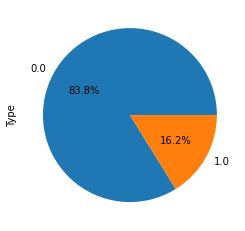

In [ ]:
# 샘플링 이전 데이터셋 비율 및 개수 확인 (Good : 83.8%, Bad : 16.2%)
data = lc_df.copy()

print(data['depvar'].value_counts())
data.groupby('depvar').size().plot(kind='pie', y = 'depvar', label = "Type", autopct='%1.1f%%')

In [ ]:
# ROS 기법을 이용한 데이터 샘플링 진행
train_X_os, train_y_os = RandomOverSampler(random_state = 55).fit_resample(train_X, train_y)

In [ ]:
train_y_os.value_counts()

0.0    732721
1.0    732721
Name: depvar, dtype: int64

## 3. 모델 생성



- 이진 분류에 강점을 보이는 Logistic Regression을 중심으로 분석 진행
    
  (1) 5조 선택 변수로 분석
    
  (2) 설명력이 높다고 판단되는 변수 추출
    
      ① 직관적 제거
      ② 다중공선성 확인 및 제거
      ③ Lasso / 전진선택 / 후진제거 / stepwise

In [ ]:
# 모델 정확도 확인 함수 정의

def print_score(true, pred, train = True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict = True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict = True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

#### 3-1. 5조가 선택한 변수를 통한 분석 진행

- 변수들의 data  추출

In [ ]:
selected_5 = ['emp_length12', 'home_ownership12', 'mths_since_last_delinq1', 'mths_since_last_major_derog1', 'mths_since_last_record1', 'mths_since_rcnt_il_a', 'mths_since_rcnt_il_b', 'mths_since_rcnt_il_c', 
              'mths_since_recent_bc', 'mths_since_recent_bc_dlq1', 'mths_since_recent_inq_a', 'mths_since_recent_inq_b', 'mths_since_recent_inq_c', 'delinq_2yrs_a', 'delinq_2yrs_b', 'delinq_2yrs_c', 
              'fico_range_low_a', 'inq_last_6mths_a', 'inq_last_6mths_b', 'inq_last_6mths_c', 'collections_12_mths_ex_med_a', 'acc_now_delinq_a', 'pub_rec_bankruptcies_a', 'tax_liens_a', 'installment_a', 
              'annual_inc_a', 'collection_recovery_fee_a', 'dti_a']

train_X_os1 = train_X_os[selected_5]
test_X1 = test_X[selected_5]

- 로지스틱 회귀분석 진행
  - 정확도가 상당히 낮음(Train Set 정확도 60.29%, Test Set 정확도 58.78%)
  - 검정력(recall) 역시 낮음 (Train Set 62.73%, Test Set 62.76%)
  - AUC 역시 0.65로 낮음

In [ ]:
# 로지스틱 회귀분석 모델 생성
lr_clf = LogisticRegression() 

# 모델 학습 진행
lr_clf.fit(train_X_os1, train_y_os)

LogisticRegression()

In [ ]:
# 모델 정확도 확인
train_y_pred = lr_clf.predict(train_X_os1)
test_y_pred = lr_clf.predict(test_X1)

print_score(train_y_os, train_y_pred, train = True)
print_score(test_y, test_y_pred, train = False)

Train Result:
Accuracy Score: 60.29%
_______________________________________________
CLASSIFICATION REPORT:
                     0.0            1.0  accuracy     macro avg  weighted avg
precision       0.608233       0.598157  0.602949  6.031951e-01  6.031951e-01
recall          0.578539       0.627359  0.602949  6.029491e-01  6.029491e-01
f1-score        0.593015       0.612410  0.602949  6.027124e-01  6.027124e-01
support    732721.000000  732721.000000  0.602949  1.465442e+06  1.465442e+06
_______________________________________________
Confusion Matrix: 
 [[423908 308813]
 [273042 459679]]

Test Result:
Accuracy Score: 58.78%
_______________________________________________
CLASSIFICATION REPORT:
                     0.0           1.0  accuracy      macro avg   weighted avg
precision       0.890277      0.223045  0.587797       0.556661       0.782789
recall          0.580141      0.627666  0.587797       0.603903       0.587797
f1-score        0.702502      0.329131  0.587797      

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


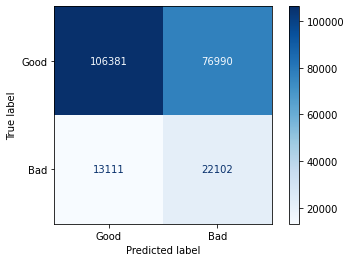

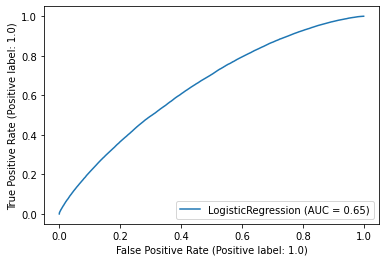

In [ ]:
# confusion matrix, AUC-ROC 커브 생성

disp = plot_confusion_matrix(lr_clf, test_X1, test_y, cmap='Blues', values_format='d', display_labels=['Good', 'Bad'])
disp = plot_roc_curve(lr_clf, test_X1, test_y)

#### 3-2. 변수 선택

- 우리는 과적합을 최대한 낮추면서 정확도도 높일 수 있는 방안을 찾는 것이 중요 -> 이를 위해서는 가장 설명력이 높은 변수들을 몇개만 고르는 것이 바람직해보임

- 직관적 판단에 의한 제거 변수 목록

      - 필요x 제거 : purpose, issue_d, elapsed_t, addr_state, mths_since_recent_revol_delinq
      - 범주화로 제거 : emp_length 1 ~ 12, home_ownership 1 ~ 6, mths_since_last_delinq 2 ~ 11, mths_since_last_major_derog 2 ~ 11, mths_since_last_record 2 ~ 11, mths_since_rcnt_il 1 ~ 11, mths_since_recent_bc 1 ~ 11, mths_since_recent_bc_dlq 2 ~ 11, mths_since_recent_inq 1  ~ 10
      - 관련 변수 제거 : installment(loan_amnt, funded_amnt, funded_amnt_inv, total_pymnt, total_pymnt_inv), recoveries(collection_recovery_fee), fico_range_low(fico_range_high), last_fico_range_low(last_fico_range_high), out_prncp(out_prncp_inv), initial_list_status1(initial_list_status2), mths_since_recent_inq_b(mths_since_recent_inq_c), total_rec_int(total_rec_prncp)
      - 원래 변수 1개로 처리되던 것들은 따로 범주화 진행 X

- 다중 공선성의 존재나 관련 변수가 존재하는 경우 먼저 제거한 이후 아래 방법에 따른 변수의 유효성 확인 및 이들을 통한 변수 선택
  - 전진선택법
  - 후진제거법
  - stepwise
  - Lasso, Ridge

3-2-1. 변수끼리의 다중공선성 확인
  
  - 다중공선성 확인을 진행할 때는 스케일링 전 데이터 이용
  - Corr 값을 이용한 표 시각화
  - VIF 함수 실행
  - 결과
    - 'pub_rec' 함수의 VIF 값이 11.65로 높게 나타났다. 상관관계를 나타낸 표에서도 'pub_rec_bankruptcies', 'tax_liens' 변수와 높은 양의 관계를, 'mths_since_last_record1' 변수와는 높은 음의 관계를 갖고 있다. 제외

In [ ]:
check_list = ['int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'total_rec_int', 
              'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt', 'last_fico_range_low', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'chargeoff_within_12_mths', 'delinq_amnt', 
              'pub_rec_bankruptcies', 'tax_liens', 'verification_status1', 'verification_status2', 'verification_status3', 'initial_list_status1', 'debt_settlement_flag1', 'term1', 'mths_since_last_delinq1', 
              'mths_since_last_major_derog1', 'mths_since_last_record1', 'mths_since_recent_bc_dlq1', 'emp_length', 'home_ownership12', 'mths_since_rcnt_il_a', 'mths_since_rcnt_il_b', 'mths_since_rcnt_il_c', 
              'mths_since_recent_bc', 'mths_since_recent_inq_a', 'mths_since_recent_inq_b']

data = X[check_list]

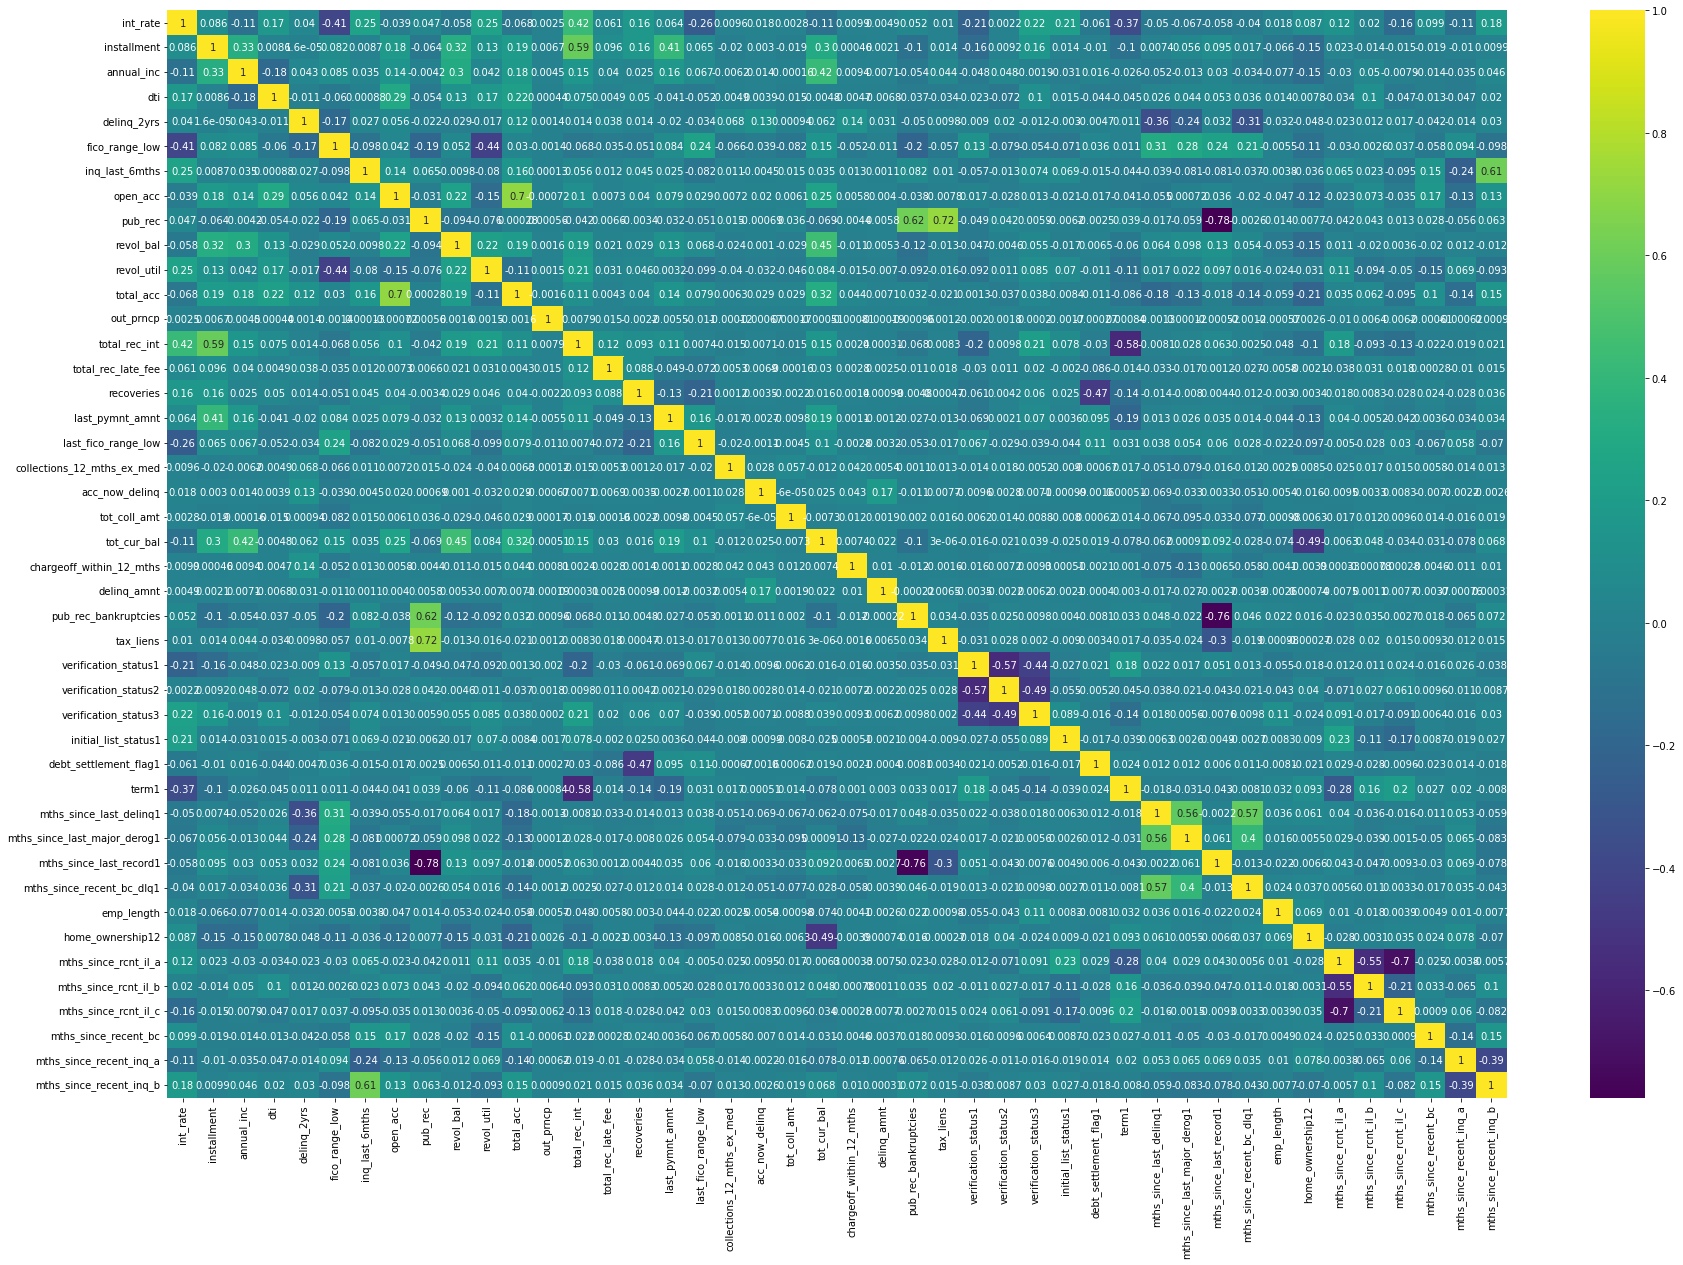

In [ ]:
# 변수끼리의 상관성 확인

plt.figure(figsize=(30, 20))
sns.heatmap(data.corr(), annot=True, cmap='viridis')

In [ ]:
vif = pd.DataFrame()
lst = []

# 독립변수의 개수 만큼 반복
for i in range(data.shape[1]):
    v = variance_inflation_factor(data.values, i) # 컬럼을 정수로 지정한다.
    lst.append(v)
    
vif["VIF Factor"] = lst
vif["features"] = data.columns
vif

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,2.070037,int_rate
1,3.205486,installment
2,1.407689,annual_inc
3,1.325183,dti
4,1.235429,delinq_2yrs
5,2.140847,fico_range_low
6,1.705608,inq_last_6mths
7,2.299679,open_acc
8,11.059497,pub_rec
9,1.478966,revol_bal


3-2-2. 'pub_rec' 컬럼을 제외한 데이터 추출 및 Set 생성

In [ ]:
check_list2 = ['int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'total_rec_int', 
               'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt', 'last_fico_range_low', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'chargeoff_within_12_mths', 'delinq_amnt', 
               'pub_rec_bankruptcies', 'tax_liens', 'verification_status1', 'verification_status2', 'verification_status3', 'initial_list_status1', 'debt_settlement_flag1', 'term1', 'mths_since_last_delinq1', 
               'mths_since_last_major_derog1', 'mths_since_last_record1', 'mths_since_recent_bc_dlq1', 'emp_length', 'home_ownership12', 'mths_since_rcnt_il_a', 'mths_since_rcnt_il_b', 'mths_since_rcnt_il_c', 
               'mths_since_recent_bc', 'mths_since_recent_inq_a', 'mths_since_recent_inq_b']

train_X_os2 = train_X_os[check_list2]
test_X2 = test_X[check_list2]

3-2-3. 변수 선택을 위한 분석 진행

- Lasso 분석 진행
  
  - alpha 값이 0.005일 때 정확도가 가장 높다.(threshold는 0.5)
  - 이 경우 선택된 변수는 아래와 같다.
    - 'int_rate', 'installment', 'dti', 'open_acc', 'revol_util', 'out_prncp',
 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt',
 'last_fico_range_low', 'tot_cur_bal', 'verification_status1',
 'debt_settlement_flag1', 'term1', 'mths_since_recent_inq_b'

In [ ]:
lambda_list = [10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005]
thres_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
df_acc = pd.DataFrame(index = thres_list, columns = lambda_list)    # 정확도 값을 넣을 데이터프레임 생성

for value in lambda_list :
  # 모델 생성 및 학습
  lasso_model = Lasso(alpha = value)
  lasso_model.fit(train_X_os2, train_y_os)
    
  # Test 데이터 예측
  test_y_pred = lasso_model.predict(test_X2)

  for thres in thres_list :
    # threshold 값 기준으로 y값 0 / 1로 분류
    Y = test_y_pred.copy()
    Y[Y > thres] = 1
    Y[Y <= thres] = 0
    Y.astype(int)
    
    # Confusion matrix 생성 후 정확도 확인
    cfmat = confusion_matrix(test_y, Y)
    acc = (cfmat[0, 0] + cfmat[1, 1]) / np.sum(cfmat)

    df_acc.loc[thres, value] = acc

In [ ]:
df_acc    # threshold가 index, alpha 값이 column인 데이터프레임

,10.000,5.000,1.000,0.500,0.100,0.050,0.010,0.005
0.1,0.161096,0.161096,0.161096,0.161096,0.173723,0.22945,0.299413,0.319145
0.2,0.161096,0.161096,0.161096,0.161096,0.199077,0.282939,0.394841,0.435032
0.3,0.161096,0.161096,0.161096,0.161096,0.266941,0.37683,0.569008,0.622635
0.4,0.161096,0.161096,0.161096,0.161096,0.44328,0.553654,0.791787,0.831667
0.5,0.838904,0.838904,0.838904,0.838904,0.936189,0.849106,0.923146,0.933815
0.6,0.838904,0.838904,0.838904,0.838904,0.889484,0.90244,0.930558,0.934176
0.7,0.838904,0.838904,0.838904,0.838904,0.864267,0.87721,0.900963,0.907322
0.8,0.838904,0.838904,0.838904,0.838904,0.852926,0.860296,0.880906,0.886259
0.9,0.838904,0.838904,0.838904,0.838904,0.846768,0.851572,0.869968,0.87344


In [ ]:
ls_0005 = Lasso(alpha = 0.005)
ls_0005.fit(train_X_os2, train_y_os)

# feature 확인
feature_selected = np.array(train_X_os2.columns)
print(feature_selected[np.where(ls_0005.coef_ != 0)])

['int_rate' 'installment' 'dti' 'open_acc' 'revol_util' 'out_prncp'
 'total_rec_int' 'total_rec_late_fee' 'recoveries' 'last_pymnt_amnt'
 'last_fico_range_low' 'tot_cur_bal' 'verification_status1'
 'debt_settlement_flag1' 'term1' 'mths_since_recent_inq_b']


- 전진선택법 진행
  - 선택된 변수는 아래와 같다.
    - 'recoveries', 'last_fico_range_low', 'last_pymnt_amnt', 'installment',
 'total_acc', 'debt_settlement_flag1', 'out_prncp', 'delinq_2yrs', 'pub_rec_bankruptcies'

In [ ]:
feature_columns = list(train_X_os2.columns)
selected_features = []    # 유효 변수 저장 리스트 생성
selected_df = pd.DataFrame()    # 결과 저장 데이터프레임 생성
i = 1

while True :
  print('======================== step ' + str(i) + '========================')    # 스텝마다 시작을 알림
  for x in selected_features :    # 이미 유효한 변수로 선택된 변수들을 삭제
    if x in feature_columns :
      feature_columns.remove(x)
  
  df_aic = pd.DataFrame()    # 모델별 AIC값 저장 데이터프레임 생성

  for col in feature_columns :
    temp_list = selected_features.copy()
    temp_list.append(col)    # 유효 변수 + 각 변수 합한 리스트
    temp_X = train_X_os2[temp_list]    # 위에서 생성된 리스트 토대로 데이터프레임 추출

    temp_X = sm.add_constant(temp_X, has_constant = "add")    # 상수항 컬럼 더하기

    model = sm.Logit(train_y_os, temp_X)
    try :
      results = model.fit(method = 'bfgs')    # 로지스틱 회귀분석 실행
      df_aic = df_aic.append({'feature' : col, 'AIC' : results.aic} , ignore_index=True)    # 모델별 추가된 컬럼 및 AIC값 저장
    except Exception as e :
      pass
  
  # 반복문에서 생성된 데이터프레임에서 가장 작은 AIC 값을 가진 변수 및 AIC 값 추출
  selected_df = selected_df.append({'feature' : df_aic[df_aic['AIC'] == df_aic.min(axis = 0)[1]].iloc[0,0], 
                                    'AIC' : df_aic[df_aic['AIC'] == df_aic.min(axis = 0)[1]].iloc[0,1]} , ignore_index=True)
  selected_features.append(df_aic[df_aic['AIC'] == df_aic.min(axis = 0)[1]].iloc[0,0])

  i += 1

  print('Selected Features : ' + df_aic[df_aic['AIC'] == df_aic.min(axis = 0)[1]].iloc[0,0] + '  //  AIC : ' + str(df_aic[df_aic['AIC'] == df_aic.min(axis = 0)[1]].iloc[0,1]))

  if len(selected_df) >= 2 :
    if selected_df.iloc[-1, 1] > selected_df.iloc[-2, 1] :
      break

selected_df.to_csv('/content/gdrive/My Drive/python/data3/forward_selection.csv', index = False)

======================== step 1========================


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.648779
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.692500
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.690194
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.686739
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.693014
         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.678245
         Iterations: 9
         Function evaluations: 12
         Gradi

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.488943
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.401569
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.693039
         Iterations: 6
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 0.693137
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.693145
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.688688
         Iterations: 8
         Function evaluations: 9
         Gr

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.283523
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.281283
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.279925
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.290439
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.291892
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.293085
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.283325
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.283660
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.284122
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.299308
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.281647
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.283411
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.282905
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.233379
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220128
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.283641
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.283856
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.283785
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.281077
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.283279
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.283099
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.293658
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.283121
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.284859
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.285405
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.285618
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.286376
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.289414
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.285324
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.285364
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.286654
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.286947
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.286572
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.286281
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.284444
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.285754
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.287203
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.286835
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.284669
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.289728
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.285651
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Selected Features : last_fico_range_low  //  AIC : 645174.7355616946
======================== step 3========================
         Current function value: 0.218819
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220688
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.219978
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.218382
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.219820
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220359
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220616
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220169
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220798
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220498
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.219920
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.219757
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220689
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220578
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177891
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220127
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220554
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220552
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220499
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220128
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220553
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220123
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220127
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220011
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.221004
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220315
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.221171
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.216073
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.217749
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220609
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220998
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.221364
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.221207
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220489
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.221662
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.221075
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220778
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220408
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.221474
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220544
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.221018
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Selected Features : last_pymnt_amnt  //  AIC : 521385.66941560135
======================== step 4========================
         Current function value: 0.174642
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.172402
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178424
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.176560
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177815
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.181796
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.180406
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177064
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177679
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177797
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.175795
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177642
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177784
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177767
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177891
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177875
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177865
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177798
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177891
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177891
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177862
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177891
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178763
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177796
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177897
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178290
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178733
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.172820
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177463
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178211
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178742
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177681
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.180119
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.179304
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177119
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.181149
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.179416
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178860
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.181870
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178727
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Selected Features : installment  //  AIC : 505299.6701300019
======================== step 5========================
         Current function value: 0.176779
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.186857
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.175581
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.172298
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.179069
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.173761
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.175299
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.186696
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174443
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171288
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.172188
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184566
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.173454
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.172402
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.173899
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177363
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.179930
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.172402
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.173925
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.172304
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.172401
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.187693
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.188198
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.187046
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.186584
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.172081
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183051
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.186180
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185991
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.187276
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.181605
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.186398
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.187803
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.186617
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.186686
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.186487
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.187485
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.187032
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.187169
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Selected Features : total_acc  //  AIC : 502036.77363284223
======================== step 6========================
         Current function value: 0.174463
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.186203
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.175705
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171149
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177782
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.173181
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.173742
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.186188
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.172925
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171064
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183950
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.172415
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171288
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.172590
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.176699
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.181193
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171288
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.172504
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171208
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171287
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.187199
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.188007
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.186743
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185489
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170580
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.182695
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185441
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185156
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.186796
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.180864
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185954
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.187060
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.186258
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.187118
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.186850
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.187018
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.186151
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.186799
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Selected Features : debt_settlement_flag1  //  AIC : 499962.84124189575
======================== step 7========================
         Current function value: 0.174833
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184470
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171579
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170468
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174728
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171183
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.172213
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183848
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171980
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170313
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178968
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.179659
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170579
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171479
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174937
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.181049
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170580
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171126
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170492
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170579
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185329
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185424
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183642
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184206
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177730
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183989
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.181877
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174777
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184270
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184774
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.182546
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184272
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185818
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184424
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183077
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184460
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183324
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Selected Features : out_prncp  //  AIC : 499184.7813656556
======================== step 8========================
         Current function value: 0.174609
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184046
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171394
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170200
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174440
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170930
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.172042
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183577
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171781
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178842
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.179347
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170313
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171190
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174742
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.180839
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170313
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170884
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170225
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170313
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185041
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185148
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183335
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183913
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177371
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183709
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.181715
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174789
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184016
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184472
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.182285
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183968
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185509
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184144
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.182786
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184160
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183035
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Selected Features : delinq_2yrs  //  AIC : 498855.58726193523
======================== step 9========================
         Current function value: 0.174556
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184041
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171315
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174398
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170819
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171944
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183555
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171678
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178814
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.179305
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170200
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171090
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174664
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.180817
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170200
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170774
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170113
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170200
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185030
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185134
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183321
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183896
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177339
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183701
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.181689
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174706
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184012
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184464
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.182268
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183956
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185500
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184131
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.182767
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184146
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183013
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Selected Features : pub_rec_bankruptcies  //  AIC : 498602.90867755923
======================== step 10========================
         Current function value: 0.174507
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184023
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171217
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174314
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170756
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171858
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183516
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171608
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178767
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.179251
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170113
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171005
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174589
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.180777
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170113
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170688
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170113
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184998
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185096
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183285
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183857
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.177276
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183665
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.181634
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174424
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183973
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184431
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.182223
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.183916
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185464
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184091
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.182723
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.184110
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.182978
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Selected Features : tax_liens  //  AIC : 498603.44779711706


- 후진제거법
  - 선택된 변수는 아래와 같다.
    - 'annual_inc', 'debt_settlement_flag1', 'dti', 'emp_length', initial_list_status1', 'inq_last_6mths', 'installment', 'int_rate', 'last_fico_range_low', 'last_pymnt_amnt', 'mths_since_last_major_derog1', 'mths_since_rcnt_il_a', 'mths_since_rcnt_il_b', 'mths_since_rcnt_il_c', 'mths_since_recent_bc_dlq1', 'out_prncp', 'pub_rec_bankruptcies', 'recoveries', 'revol_util', 'term1', 'total_acc', 'total_rec_int', 'total_rec_late_fee', 'verification_status1', 'verification_status2', 'verification_status3'

In [ ]:
feature_columns = list(train_X_os2.columns)
deleted_features = []    # 제거 변수 저장 리스트 생성
deleted_df = pd.DataFrame()    # 결과 저장 데이터프레임 생성
i = 1

while True :
  print('========step ' + str(i) + '========')    # 스텝마다 시작을 알림
  for x in deleted_features :    # 제거된 변수들 제외
    if x in feature_columns :
      feature_columns.remove(x)
  
  df_aic = pd.DataFrame()    # 모델별 AIC값 저장 데이터프레임 생성

  for col in feature_columns :
    temp_list = feature_columns.copy()
    temp_list.remove(col)    # 변수 별로 하나씩 제거
    temp_X = train_X_os2[temp_list]    # 위에서 생성된 리스트 토대로 데이터프레임 추출

    temp_X = sm.add_constant(temp_X, has_constant = "add")    # 상수항 컬럼 더하기

    model = sm.Logit(train_y_os, temp_X)
    try :
      results = model.fit(method = 'bfgs')    # 로지스틱 회귀분석 실행
      df_aic = df_aic.append({'feature' : col, 'AIC' : results.aic} , ignore_index=True)    # 모델별 제거된 컬럼 및 AIC값 저장
    except Exception as e :
      pass
  
  # 반복문에서 생성된 데이터프레임에서 가장 작은 AIC 값을 가진 변수 및 AIC 값 추출
  deleted_df = deleted_df.append({'feature' : df_aic[df_aic['AIC'] == df_aic.min(axis = 0)[1]].iloc[0,0], 
                                  'AIC' : df_aic[df_aic['AIC'] == df_aic.min(axis = 0)[1]].iloc[0,1]} , ignore_index=True)
  deleted_features.append(df_aic[df_aic['AIC'] == df_aic.min(axis = 0)[1]].iloc[0,0])

  i += 1

  print('Deleted Features : ' + df_aic[df_aic['AIC'] == df_aic.min(axis = 0)[1]].iloc[0,0] + '  //  AIC : ' + str(df_aic[df_aic['AIC'] == df_aic.min(axis = 0)[1]].iloc[0,1]))

  if len(deleted_df) >= 2 :
    if deleted_df.iloc[-1, 1] > deleted_df.iloc[-2, 1] :
      break

deleted_df.to_csv('/content/gdrive/My Drive/python/data3/backward_selection.csv', index = False)

========step 1========


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


         Current function value: 0.162160
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178289
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157665
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157982
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157478
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157455
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157486
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157439
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157207
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157726
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157691
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157918
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.175030
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157971
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.252527
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.224209
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.196305
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157479
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157484
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157480
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157346
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157479
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157481
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157496
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157479
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158990
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158311
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158546
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157563
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.159405
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.169034
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157470
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157406
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157066
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157373
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157842
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157417
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158582
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158317
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158551
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157414
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157504
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157336
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Deleted Features : mths_since_last_record1  //  AIC : 460424.77902938996
========step 2========
         Current function value: 0.161747
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178128
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157238
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157549
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157065
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157069
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157076
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157025
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156798
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157332
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157277
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157509
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.175070
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157625
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.252445
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.222572
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.196508
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157066
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157073
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157069
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156841
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157066
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157070
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157079
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157066
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158699
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157914
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158175
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157166
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.159200
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.168925
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157117
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156977
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156959
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157360
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156994
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158064
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157983
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158227
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157026
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157096
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156983
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Deleted Features : revol_bal  //  AIC : 459637.0272498684
========step 3========
         Current function value: 0.161625
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178317
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156686
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157286
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156797
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156801
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156808
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156665
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157072
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157009
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157244
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174976
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157415
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.252339
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.222471
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.196514
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156798
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156798
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156800
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156419
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156798
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156802
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156812
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156798
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158445
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157646
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157922
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156887
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158907
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.168796
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156779
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156696
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156660
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157127
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156695
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157851
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157766
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157977
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156764
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156828
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156705
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Deleted Features : tot_cur_bal  //  AIC : 458522.75373748335
========step 4========
         Current function value: 0.161296
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178339
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156771
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156939
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156418
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156411
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156433
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156150
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156836
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156620
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156872
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174856
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157081
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.252044
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.223177
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.196783
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156419
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156365
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156349
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156419
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156442
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156434
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156419
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158081
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157289
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157602
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156509
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158627
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.168525
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156410
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156319
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156276
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156699
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156398
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157522
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157470
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157670
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156393
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156463
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156344
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Deleted Features : open_acc  //  AIC : 457732.6454706069
========step 5========
         Current function value: 0.161147
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178720
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156656
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156777
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156149
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156126
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156166
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156483
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156454
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156607
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174736
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157030
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.251830
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.222359
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.196770
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156150
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156050
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156020
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156150
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156182
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156165
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156150
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157733
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156996
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157351
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156233
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158425
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.168322
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156112
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156085
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156047
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156455
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156178
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157270
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157234
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157318
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156109
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156181
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156060
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Deleted Features : tot_coll_amt  //  AIC : 457351.3574384134
========step 6========
         Current function value: 0.161137
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178704
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156551
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156715
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156019
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155998
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156038
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156441
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156326
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156480
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174614
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156996
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.251814
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.222379
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.196738
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156020
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155853
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156020
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156062
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156036
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156020
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157563
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156850
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157223
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156098
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158337
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.168187
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156002
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156002
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155952
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156336
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156050
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157119
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157113
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157161
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155978
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156045
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155938
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Deleted Features : acc_now_delinq  //  AIC : 456857.75764686696
========step 7========
         Current function value: 0.161133
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178711
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156459
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156671
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155852
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155831
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155871
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156408
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156159
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156314
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174421
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156991
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.251809
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.222380
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.196716
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155853
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155853
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155841
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155868
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155853
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157348
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156657
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157059
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155925
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158221
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.168028
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155872
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155869
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155836
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156190
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155878
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156934
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156965
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156973
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155821
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155873
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155796
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Deleted Features : mths_since_recent_inq_b  //  AIC : 456691.1583763174
========step 8========
         Current function value: 0.161199
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178684
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156425
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156666
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155795
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155769
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155920
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156316
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156116
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156260
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174536
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156906
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.251736
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.221803
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.196733
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155796
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155796
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155787
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155812
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155796
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157273
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156616
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157027
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155891
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158137
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.168041
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155767
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155812
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155770
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156162
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155805
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156907
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156945
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156987
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155839
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155803
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Deleted Features : mths_since_last_delinq1  //  AIC : 456602.5879777833
========step 9========
         Current function value: 0.161382
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178647
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156414
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156720
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155766
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155737
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155887
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156299
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156077
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156228
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174700
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156868
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.251391
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220292
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.196892
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155767
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155767
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155756
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155784
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155767
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157271
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156614
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156995
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155854
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158311
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.168101
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156078
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156115
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156122
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155767
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156946
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156945
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157003
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155806
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155776
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Deleted Features : fico_range_low  //  AIC : 456514.3066495759
========step 10========
         Current function value: 0.161473
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178652
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156380
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156707
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155737
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155857
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156339
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156049
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156198
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174599
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156832
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.251367
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220510
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.197078
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155737
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155737
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155726
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155755
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155737
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157256
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156579
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156969
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155824
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158270
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.168068
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156050
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156097
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156095
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155726
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156920
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156904
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156969
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155762
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155735
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Deleted Features : delinq_amnt  //  AIC : 456477.8749999296
========step 11========
         Current function value: 0.161477
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178652
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156379
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156708
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155725
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155845
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156338
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156038
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156186
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174598
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156832
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.251364
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220512
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.197076
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155726
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155726
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155743
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155726
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157242
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156567
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156958
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155813
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158261
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.168058
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156039
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156084
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156083
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155716
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156906
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156893
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156956
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155751
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155722
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Deleted Features : home_ownership12  //  AIC : 456446.6778494141
========step 12========
         Current function value: 0.161671
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178602
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156397
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156669
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155715
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155825
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156323
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156000
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156177
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174695
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156811
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.251352
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220960
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.197289
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155716
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155716
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155733
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155716
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157140
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156538
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156950
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155803
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158282
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.167883
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156018
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156078
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156101
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156924
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156885
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156883
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155689
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155700
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Deleted Features : mths_since_recent_bc  //  AIC : 456365.87073995965
========step 13========
         Current function value: 0.162202
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178682
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156340
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156602
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155689
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155817
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156401
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155997
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156150
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174685
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156803
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.251410
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220777
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.197487
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155689
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155689
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155705
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155689
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157074
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156525
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156919
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155767
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158253
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.167723
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155924
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156016
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156155
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156914
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156862
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156854
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155669
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Deleted Features : mths_since_recent_inq_a  //  AIC : 456306.4423555893
========step 14========
         Current function value: 0.162035
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178690
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156320
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156579
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155669
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155829
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156363
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155992
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156130
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174759
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156798
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.251409
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220862
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.197591
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155669
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155669
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155686
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155669
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157057
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156505
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156899
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155744
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158248
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.167730
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155902
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155982
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156133
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156881
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156841
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156856
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Deleted Features : delinq_2yrs  //  AIC : 456304.1048413463
========step 15========
         Current function value: 0.162034
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178690
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156320
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156579
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155829
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156363
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155992
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156130
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174760
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156798
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.251407
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220858
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.197593
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155669
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155669
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155686
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155669
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157057
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156505
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156898
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155744
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158249
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.167732
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155902
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155983
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156133
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156880
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156841
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156856
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Deleted Features : collections_12_mths_ex_med  //  AIC : 456302.0592483771
========step 16========
         Current function value: 0.162034
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178690
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156320
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156579
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155829
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156363
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155992
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156130
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174760
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156798
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.251407
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220858
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.197593
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155669
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155686
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155669
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157057
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156505
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156898
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155744
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158249
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.167732
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155902
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155983
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156133
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156880
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156841
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156856
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Deleted Features : tax_liens  //  AIC : 456300.02859105734
========step 17========
         Current function value: 0.162034
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178690
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156320
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156579
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155829
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156363
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155992
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156130
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174760
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156798
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.251407
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220858
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.197593
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155669
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155686
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157057
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156505
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156898
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155744
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158249
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.167732
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155902
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155983
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156133
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156880
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156841
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156856
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Deleted Features : chargeoff_within_12_mths  //  AIC : 456298.1968556806
========step 18========
         Current function value: 0.162034
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.178690
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156320
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156579
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155829
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156363
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155992
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156130
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.174760
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156798
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.251407
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.220859
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.197593
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155686
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.157057
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156505
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156898
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155744
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.158249
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.167732
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155902
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.155983
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156133
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156880
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156841
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.156856
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Deleted Features : pub_rec_bankruptcies  //  AIC : 456346.1467269085


- Stepwise 기법 진행
  - 결과는 전진선택법을 통해 변수를 선택한 경우와 같다.

In [ ]:
# 마지막 전진 선택법에서 후진제거법을 진행
# 전진 선택법에서 선택된 변수들
ab = ['recoveries', 'last_fico_range_low', 'last_pymnt_amnt', 'installment', 'total_acc', 'debt_settlement_flag1', 'out_prncp', 'delinq_2yrs', 'pub_rec_bankruptcies']
feature_columns = list(train_X_os2.columns)

# Step1
deleted_features = list(set(feature_columns) - set(ab))    # 제거 변수 저장 리스트 생성 (여기서는 전진선택법에서 선택되지 않은 변수들)

for x in deleted_features :    # 제거된 변수들 제외
  if x in feature_columns :
    feature_columns.remove(x)

df_aic = pd.DataFrame()    # 모델별 AIC값 저장 데이터프레임 생성

for col in feature_columns :
  temp_list = feature_columns.copy()
  temp_list.remove(col)    # 변수 별로 하나씩 제거
  temp_X = train_X_os2[temp_list]    # 위에서 생성된 리스트 토대로 데이터프레임 추출

  temp_X = sm.add_constant(temp_X, has_constant = "add")    # 상수항 컬럼 더하기

  model = sm.Logit(train_y_os, temp_X)
  try :
    results = model.fit(method = 'bfgs')    # 로지스틱 회귀분석 실행
    df_aic = df_aic.append({'feature' : col, 'AIC' : results.aic} , ignore_index=True)    # 모델별 제거된 컬럼 및 AIC값 저장
  except Exception as e :
    pass

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


         Current function value: 0.175823
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170225
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.171639
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170382
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.271290
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.215638
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.231553
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170200
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.170845
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
df_aic    # 제거할 변수 존재하지 않음... stepwise = 전진선택

,feature,AIC
0,installment,515335.056718
1,delinq_2yrs,498928.147058
2,total_acc,503072.022033
3,out_prncp,499389.060751
4,recoveries,795137.807517
5,last_pymnt_amnt,632026.583906
6,last_fico_range_low,678672.045641
7,pub_rec_bankruptcies,498855.587262
8,debt_settlement_flag1,500745.061734


## 4. 선택된 변수들로 학습 진행 및 정확도 비교

  (1) Logistic Regression : Lasso / 전진선택 / 후진제거 / stepwise 별 변수선택에 따른 데이터셋별로 학습 진행

  (2) Random Forest : 하이퍼 파라미터 튜닝을 통해 최적의 모델 선정
  
  (3) XGBoost : 하이퍼 파라미터 튜닝을 통해 최적의 모델 선정
 

※ 모델의 정확도는 Test Set에 대한 Accuracy 및 검정력(1-b, recall)을 기준으로 하며 AUC를 참고한다.

#### (1) 로지스틱 회귀

  ① Lasso 로 선택된 변수

In [ ]:
lasso_selected = ['int_rate', 'installment', 'dti', 'open_acc', 'revol_util', 'out_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt', 'last_fico_range_low', 'tot_cur_bal', 
                  'verification_status1', 'debt_settlement_flag1', 'term1', 'mths_since_recent_inq_b']

In [ ]:
# Train Set 및 Test Set 추출
train_X_os2 = train_X_os[lasso_selected]
test_X2 = test_X[lasso_selected]

train_X_os2 = sm.add_constant(train_X_os2, has_constant = "add")    # 상수항 컬럼 더하기
test_X2 = sm.add_constant(test_X2, has_constant = "add")    # 상수항 컬럼 더하기

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# Cross Validation 진행 (5-fold)
warnings.filterwarnings(action='ignore')

k = 5
lr_clf = LogisticRegression() 
cv_result = cross_val_score(lr_clf, train_X_os2, train_y_os, cv = k)    # uses R^2 as score 

print('CV Scores: ',cv_result)
print('CV scores average: ',np.sum(cv_result)/k)

warnings.filterwarnings(action='default')

In [ ]:
# 로지스틱 회귀분석 모델 생성
lr_clf1 = LogisticRegression()

# 모델 학습 진행
lr_clf1.fit(train_X_os2, train_y_os)

# 모델 정확도 확인
train_y_pred = lr_clf1.predict(train_X_os2)
test_y_pred = lr_clf1.predict(test_X2)

print_score(train_y_os, train_y_pred, train = True)
print_score(test_y, test_y_pred, train = False)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train Result:
Accuracy Score: 94.88%
_______________________________________________
CLASSIFICATION REPORT:
                     0.0            1.0  accuracy     macro avg  weighted avg
precision       0.931772       0.967304  0.948836  9.495381e-01  9.495381e-01
recall          0.968597       0.929075  0.948836  9.488359e-01  9.488359e-01
f1-score        0.949827       0.947805  0.948836  9.488159e-01  9.488159e-01
support    732721.000000  732721.000000  0.948836  1.465442e+06  1.465442e+06
_______________________________________________
Confusion Matrix: 
 [[709711  23010]
 [ 51968 680753]]

Test Result:
Accuracy Score: 96.19%
_______________________________________________
CLASSIFICATION REPORT:
                     0.0           1.0  accuracy      macro avg   weighted avg
precision       0.986249      0.848135  0.961859       0.917192       0.963999
recall          0.968032      0.929713  0.961859       0.948873       0.961859
f1-score        0.977055      0.887052  0.961859      

- threshold 값에 따른 Train Set 정확도 및 Recall 값

In [ ]:
test_y_prob = lr_clf1.predict_proba(test_X2)
threshold_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
df_thres = pd.DataFrame(index = threshold_list, columns = ['accuracy', 'recall'])

for thres in threshold_list :
  test_y_pred_prob = np.zeros(len(test_y_prob))

  for i in range(len(test_y_prob)) :
    if test_y_prob[i][1] > thres :
      test_y_pred_prob[i] = 1
  
  tp = confusion_matrix(test_y, test_y_pred_prob)[0][0]
  fn = confusion_matrix(test_y, test_y_pred_prob)[0][1]
  fp = confusion_matrix(test_y, test_y_pred_prob)[1][0]
  tn = confusion_matrix(test_y, test_y_pred_prob)[1][1]

  accuracy = (tp + tn) / (tp + fn + fp + tn)
  recall = tn / (fp + tn)

  df_thres.loc[thres, 'accuracy'] = accuracy
  df_thres.loc[thres, 'recall'] = recall

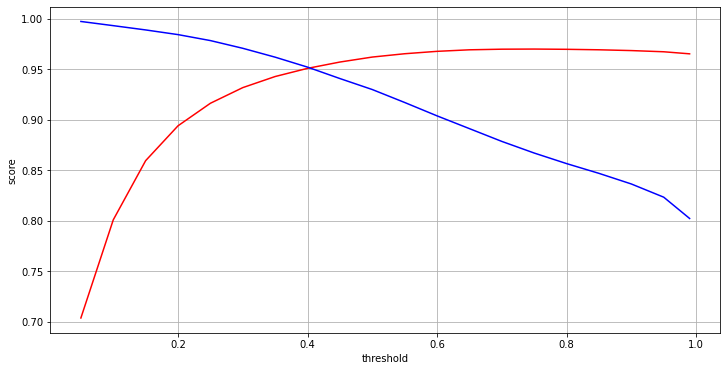

In [ ]:
# 시각화
fig, ax1 = plt.subplots(figsize = (12, 6))

plt.plot(df_thres.index, df_thres['accuracy'], color = 'red')
plt.plot(df_thres.index, df_thres['recall'], color = 'blue')

plt.xlabel('threshold')
plt.ylabel('score')
plt.grid(True)
plt.show()

In [ ]:
# threshold 값을 0.35로 설정하여 최종 예측 결과 확인
threshold = 0.35

test_y_pred_prob = np.zeros(len(test_y_prob))

for i in range(len(test_y_prob)) :
    if test_y_prob[i][1] > threshold :
      test_y_pred_prob[i] = 1

tp = confusion_matrix(test_y, test_y_pred_prob)[0][0]
fn = confusion_matrix(test_y, test_y_pred_prob)[0][1]
fp = confusion_matrix(test_y, test_y_pred_prob)[1][0]
tn = confusion_matrix(test_y, test_y_pred_prob)[1][1]

accuracy = (tp + tn) / (tp + fn + fp + tn)
recall = tn / (fp + tn)

print(f"Accuracy Score: {accuracy * 100:.2f}%")
print(f"Recall Score: {recall * 100:.2f}%")

print(confusion_matrix(test_y, test_y_pred_prob))

Accuracy Score: 94.26%
Recall Score: 96.17%
[[172172  11199]
 [  1347  33866]]


② 전진선택볍 변수 사용

In [ ]:
forw_selected = ['recoveries', 'last_fico_range_low', 'last_pymnt_amnt', 'installment', 'total_acc', 'debt_settlement_flag1', 'out_prncp', 'delinq_2yrs', 'pub_rec_bankruptcies']

In [ ]:
# Train Set 및 Test Set 추출
train_X_os2 = train_X_os[forw_selected]
test_X2 = test_X[forw_selected]

train_X_os2 = sm.add_constant(train_X_os2, has_constant = "add")    # 상수항 컬럼 더하기
test_X2 = sm.add_constant(test_X2, has_constant = "add")    # 상수항 컬럼 더하기

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# 로지스틱 회귀분석 모델 생성
lr_clf2 = LogisticRegression()

# 모델 학습 진행
lr_clf2.fit(train_X_os2, train_y_os)

# 모델 정확도 확인
train_y_pred = lr_clf2.predict(train_X_os2)
test_y_pred = lr_clf2.predict(test_X2)

print_score(train_y_os, train_y_pred, train = True)
print_score(test_y, test_y_pred, train = False)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train Result:
Accuracy Score: 93.20%
_______________________________________________
CLASSIFICATION REPORT:
                     0.0            1.0  accuracy     macro avg  weighted avg
precision       0.911363       0.954922  0.932047  9.331422e-01  9.331422e-01
recall          0.957188       0.906906  0.932047  9.320471e-01  9.320471e-01
f1-score        0.933714       0.930295  0.932047  9.320041e-01  9.320041e-01
support    732721.000000  732721.000000  0.932047  1.465442e+06  1.465442e+06
_______________________________________________
Confusion Matrix: 
 [[701352  31369]
 [ 68212 664509]]

Test Result:
Accuracy Score: 94.91%
_______________________________________________
CLASSIFICATION REPORT:
                     0.0           1.0  accuracy      macro avg   weighted avg
precision       0.981860      0.802062  0.949072       0.891961       0.952895
recall          0.956972      0.907932  0.949072       0.932452       0.949072
f1-score        0.969257      0.851720  0.949072      

In [ ]:
test_y_prob = lr_clf2.predict_proba(test_X2)
threshold_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
df_thres = pd.DataFrame(index = threshold_list, columns = ['accuracy', 'recall'])

for thres in threshold_list :
  test_y_pred_prob = np.zeros(len(test_y_prob))

  for i in range(len(test_y_prob)) :
    if test_y_prob[i][1] > thres :
      test_y_pred_prob[i] = 1
  
  tp = confusion_matrix(test_y, test_y_pred_prob)[0][0]
  fn = confusion_matrix(test_y, test_y_pred_prob)[0][1]
  fp = confusion_matrix(test_y, test_y_pred_prob)[1][0]
  tn = confusion_matrix(test_y, test_y_pred_prob)[1][1]

  accuracy = (tp + tn) / (tp + fn + fp + tn)
  recall = tn / (fp + tn)

  df_thres.loc[thres, 'accuracy'] = accuracy
  df_thres.loc[thres, 'recall'] = recall

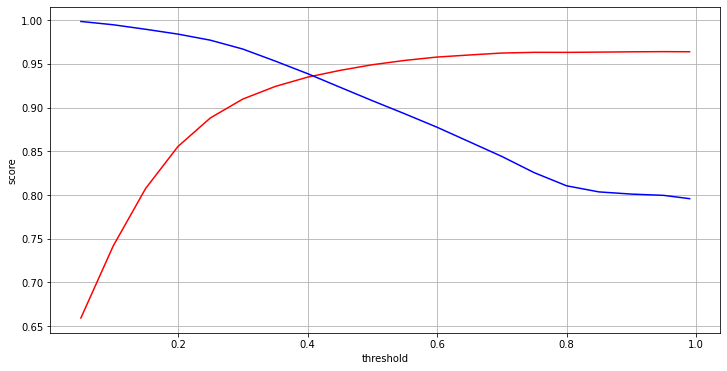

In [ ]:
# 시각화
fig, ax1 = plt.subplots(figsize = (12, 6))

plt.plot(df_thres.index, df_thres['accuracy'], color = 'red')
plt.plot(df_thres.index, df_thres['recall'], color = 'blue')

plt.xlabel('threshold')
plt.ylabel('score')
plt.grid(True)
plt.show()

In [ ]:
# threshold 값을 0.35로 설정하여 최종 예측 결과 확인
threshold = 0.35

test_y_pred_prob = np.zeros(len(test_y_prob))

for i in range(len(test_y_prob)) :
    if test_y_prob[i][1] > threshold :
      test_y_pred_prob[i] = 1

tp = confusion_matrix(test_y, test_y_pred_prob)[0][0]
fn = confusion_matrix(test_y, test_y_pred_prob)[0][1]
fp = confusion_matrix(test_y, test_y_pred_prob)[1][0]
tn = confusion_matrix(test_y, test_y_pred_prob)[1][1]

accuracy = (tp + tn) / (tp + fn + fp + tn)
recall = tn / (fp + tn)

print(f"Accuracy Score: {accuracy * 100:.2f}%")
print(f"Recall Score: {recall * 100:.2f}%")

print(confusion_matrix(test_y, test_y_pred_prob))

Accuracy Score: 92.42%
Recall Score: 95.33%
[[168443  14928]
 [  1645  33568]]


③ 후진제거법 변수 사용

In [ ]:
backw_selected = ['annual_inc', 'debt_settlement_flag1', 'dti', 'emp_length', 'initial_list_status1', 'inq_last_6mths', 'installment', 'int_rate', 'last_fico_range_low', 'last_pymnt_amnt', 
                  'mths_since_last_major_derog1', 'mths_since_rcnt_il_a', 'mths_since_rcnt_il_b', 'mths_since_rcnt_il_c', 'mths_since_recent_bc_dlq1', 'out_prncp', 'pub_rec_bankruptcies', 
                  'recoveries', 'revol_util', 'term1', 'total_acc', 'total_rec_int', 'total_rec_late_fee', 'verification_status1', 'verification_status2', 'verification_status3']

In [ ]:
# Train Set 및 Test Set 추출
train_X_os2 = train_X_os[backw_selected]
test_X2 = test_X[backw_selected]

train_X_os2 = sm.add_constant(train_X_os2, has_constant = "add")    # 상수항 컬럼 더하기
test_X2 = sm.add_constant(test_X2, has_constant = "add")    # 상수항 컬럼 더하기

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# 로지스틱 회귀분석 모델 생성
lr_clf3 = LogisticRegression()

# 모델 학습 진행
lr_clf3.fit(train_X_os2, train_y_os)

# 모델 정확도 확인
train_y_pred = lr_clf3.predict(train_X_os2)
test_y_pred = lr_clf3.predict(test_X2)

print_score(train_y_os, train_y_pred, train = True)
print_score(test_y, test_y_pred, train = False)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train Result:
Accuracy Score: 94.96%
_______________________________________________
CLASSIFICATION REPORT:
                     0.0            1.0  accuracy     macro avg  weighted avg
precision       0.932960       0.967527   0.94958  9.502439e-01  9.502439e-01
recall          0.968774       0.930387   0.94958  9.495804e-01  9.495804e-01
f1-score        0.950530       0.948594   0.94958  9.495618e-01  9.495618e-01
support    732721.000000  732721.000000   0.94958  1.465442e+06  1.465442e+06
_______________________________________________
Confusion Matrix: 
 [[709841  22880]
 [ 51007 681714]]

Test Result:
Accuracy Score: 96.22%
_______________________________________________
CLASSIFICATION REPORT:
                     0.0           1.0  accuracy      macro avg   weighted avg
precision       0.986417      0.849286  0.962211       0.917851       0.964326
recall          0.968288      0.930565  0.962211       0.949427       0.962211
f1-score        0.977268      0.888070  0.962211      

In [ ]:
test_y_prob = lr_clf3.predict_proba(test_X2)
threshold_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
df_thres = pd.DataFrame(index = threshold_list, columns = ['accuracy', 'recall'])

for thres in threshold_list :
  test_y_pred_prob = np.zeros(len(test_y_prob))

  for i in range(len(test_y_prob)) :
    if test_y_prob[i][1] > thres :
      test_y_pred_prob[i] = 1
  
  tp = confusion_matrix(test_y, test_y_pred_prob)[0][0]
  fn = confusion_matrix(test_y, test_y_pred_prob)[0][1]
  fp = confusion_matrix(test_y, test_y_pred_prob)[1][0]
  tn = confusion_matrix(test_y, test_y_pred_prob)[1][1]

  accuracy = (tp + tn) / (tp + fn + fp + tn)
  recall = tn / (fp + tn)

  df_thres.loc[thres, 'accuracy'] = accuracy
  df_thres.loc[thres, 'recall'] = recall

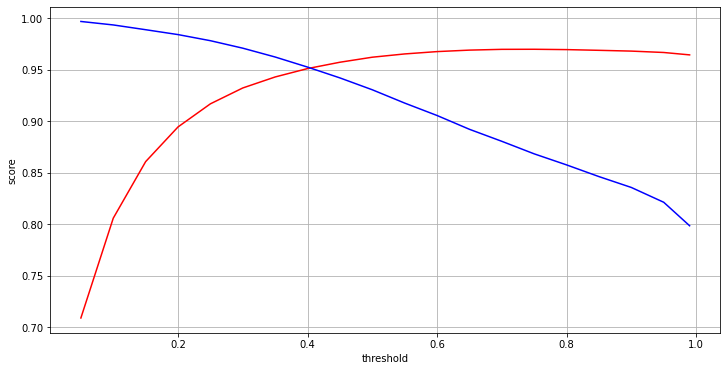

In [ ]:
# 시각화
fig, ax1 = plt.subplots(figsize = (12, 6))

plt.plot(df_thres.index, df_thres['accuracy'], color = 'red')
plt.plot(df_thres.index, df_thres['recall'], color = 'blue')

plt.xlabel('threshold')
plt.ylabel('score')
plt.grid(True)
plt.show()

In [ ]:
# threshold 값을 0.35로 설정하여 최종 예측 결과 확인
threshold = 0.35

test_y_pred_prob = np.zeros(len(test_y_prob))

for i in range(len(test_y_prob)) :
    if test_y_prob[i][1] > threshold :
      test_y_pred_prob[i] = 1

tp = confusion_matrix(test_y, test_y_pred_prob)[0][0]
fn = confusion_matrix(test_y, test_y_pred_prob)[0][1]
fp = confusion_matrix(test_y, test_y_pred_prob)[1][0]
tn = confusion_matrix(test_y, test_y_pred_prob)[1][1]

accuracy = (tp + tn) / (tp + fn + fp + tn)
recall = tn / (fp + tn)

print(f"Accuracy Score: {accuracy * 100:.2f}%")
print(f"Recall Score: {recall * 100:.2f}%")

print(confusion_matrix(test_y, test_y_pred_prob))

Accuracy Score: 94.30%
Recall Score: 96.24%
[[172239  11132]
 [  1324  33889]]


④ Stepwise 변수 진행
  - 전진선택법으로 선택한 변수와 동일하므로 따로 진행하진 않음

#### (2) Random Forest

In [ ]:
# Train Set 및 Test Set 추출
check_list2 = ['int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'total_rec_int', 
               'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt', 'last_fico_range_low', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'chargeoff_within_12_mths', 'delinq_amnt', 
               'pub_rec_bankruptcies', 'tax_liens', 'verification_status1', 'verification_status2', 'verification_status3', 'initial_list_status1', 'debt_settlement_flag1', 'term1', 'mths_since_last_delinq1', 
               'mths_since_last_major_derog1', 'mths_since_last_record1', 'mths_since_recent_bc_dlq1', 'emp_length', 'home_ownership12', 'mths_since_rcnt_il_a', 'mths_since_rcnt_il_b', 'mths_since_rcnt_il_c', 
               'mths_since_recent_bc', 'mths_since_recent_inq_a', 'mths_since_recent_inq_b']

train_X_os2 = train_X_os[check_list2]
test_X3 = test_X[check_list2]

In [ ]:
# Random Forest 모델 생성
rf_clf = RandomForestClassifier(n_estimators = 100, max_depth = 8, max_features = 'auto', min_samples_split = 6, random_state = 123)    # n_estimators는 생성할 Tree의 개수. 개수가 많을수록 정확도가 올라가지만 모델 학습 시간이 길어짐

# 모델 학습 진행
rf_clf.fit(train_X_os2, train_y_os)

# 모델 정확도 확인
train_y_pred = rf_clf.predict(train_X_os2)
test_y_pred = rf_clf.predict(test_X3)

print_score(train_y_os, train_y_pred, train = True)
print_score(test_y, test_y_pred, train = False)

Train Result:
Accuracy Score: 95.25%
_______________________________________________
CLASSIFICATION REPORT:
                     0.0            1.0  accuracy     macro avg  weighted avg
precision       0.962765       0.942744  0.952533  9.527544e-01  9.527544e-01
recall          0.941478       0.963588  0.952533  9.525331e-01  9.525331e-01
f1-score        0.952002       0.953052  0.952533  9.525273e-01  9.525273e-01
support    732721.000000  732721.000000  0.952533  1.465442e+06  1.465442e+06
_______________________________________________
Confusion Matrix: 
 [[689841  42880]
 [ 26680 706041]]

Test Result:
Accuracy Score: 94.42%
_______________________________________________
CLASSIFICATION REPORT:
                     0.0           1.0  accuracy      macro avg   weighted avg
precision       0.992558      0.756586  0.944159       0.874572       0.954544
recall          0.940487      0.963281  0.944159       0.951884       0.944159
f1-score        0.965821      0.847513  0.944159      

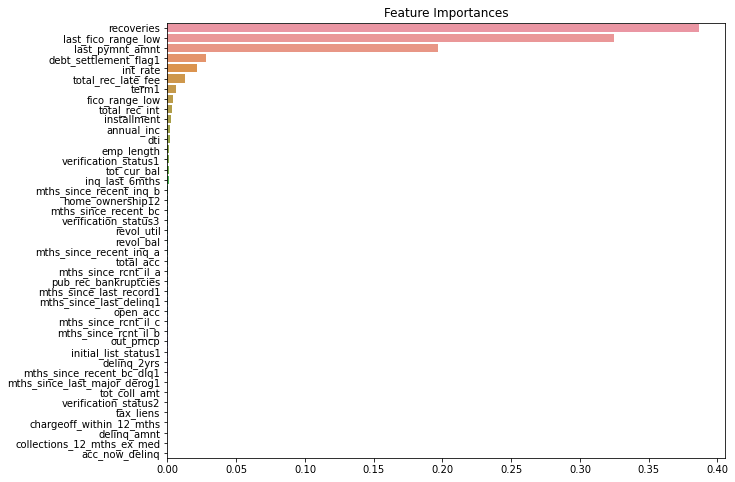

In [ ]:
ftr_importances_values = rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = test_X3.columns)
ftr_importances = ftr_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
sns.barplot(x = ftr_importances, y = ftr_importances.index)

#### (3) XGBoost 진행

In [ ]:
# XGBoost 모델 생성
xgb_clf = XGBClassifier(n_estimators = 20,  max_depth = 10, learning_rate = 0.1, random_state = 123)    # XGBoost 라이브러리 문서까지 찾아봤는데, 별다른 설명 없이 False를 추천한다 하여 False로 설정

# 모델 학습 진행
xgb_clf.fit(train_X_os2, train_y_os)

# 모델 정확도 확인
train_y_pred = xgb_clf.predict(train_X_os2)
test_y_pred = xgb_clf.predict(test_X3)

print_score(train_y_os, train_y_pred, train = True)
print_score(test_y, test_y_pred, train = False)

Train Result:
Accuracy Score: 97.24%
_______________________________________________
CLASSIFICATION REPORT:
                     0.0            1.0  accuracy     macro avg  weighted avg
precision       0.971669       0.973107  0.972387  9.723883e-01  9.723883e-01
recall          0.973148       0.971626  0.972387  9.723872e-01  9.723872e-01
f1-score        0.972408       0.972366  0.972387  9.723872e-01  9.723872e-01
support    732721.000000  732721.000000  0.972387  1.465442e+06  1.465442e+06
_______________________________________________
Confusion Matrix: 
 [[713046  19675]
 [ 20790 711931]]

Test Result:
Accuracy Score: 97.12%
_______________________________________________
CLASSIFICATION REPORT:
                     0.0           1.0  accuracy      macro avg   weighted avg
precision       0.993457      0.869251  0.971206       0.931354       0.973448
recall          0.972078      0.966660  0.971206       0.969369       0.971206
f1-score        0.982651      0.915371  0.971206      

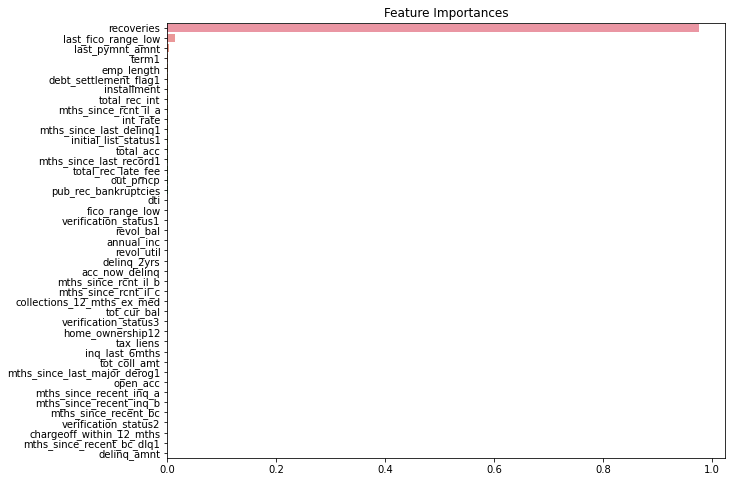

In [ ]:
ftr_importances_values = xgb_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = test_X3.columns)
ftr_importances = ftr_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
sns.barplot(x = ftr_importances, y = ftr_importances.index)

#### (4) AUC값 비교

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. U

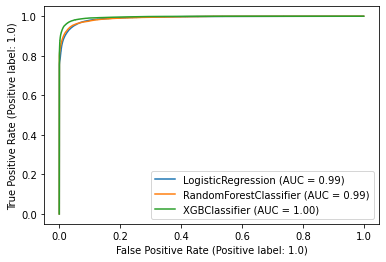

In [ ]:
disp = plot_roc_curve(lr_clf3, test_X2, test_y)
plot_roc_curve(rf_clf, test_X3, test_y, ax=disp.ax_)
plot_roc_curve(xgb_clf, test_X3, test_y, ax=disp.ax_)